In [ ]:
!git clone https://github.com/rmartinshort/text_chunking.git
!pip install -q langchain langchain-openai langchain-community langchain-huggingface langchain-text-splitters
!pip install -q datamapplot faiss-cpu sentence_transformers mxbai-rerank pytorch-ignite

Cloning into 'text_chunking'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 82 (delta 38), reused 66 (delta 26), pack-reused 0 (from 0)
Receiving objects: 100% (82/82), 29.45 KiB | 9.81 MiB/s, done.
Resolving deltas: 100% (38/38), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.7/437.7 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
os.chdir("/content/text_chunking")

from text_chunking.SemanticClusterVisualizer import SemanticClusterVisualizer
from text_chunking.datasets.test_text_dataset import TestText, TestTextNovel
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain_community.vectorstores import FAISS
from langchain.docstore.document import Document
from ignite.metrics import RougeL
from google.colab import userdata
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import re

In [ ]:
aggregate_scores = {}

In [ ]:
data = pd.read_json(path_or_buf="/content/test.jsonl", lines=True)
aggregate_scores = {}

print(len(data))
print(data.keys())
print(data["meeting_transcripts"][0])

35
Index(['topic_list', 'general_query_list', 'specific_query_list',
       'meeting_transcripts'],
      dtype='object')
[{'speaker': 'Lynne Neagle AM', 'content': "Good afternoon, everyone. Welcome to the Children, Young People and Education Committee. We've received apologies for absence from Hefin David and Jack Sargeant. Vikki Howells is substituting for Jack Sargeant. So, Vikki, welcome; it's good to see you in the committee. Item 2 this afternoon is our eleventh evidence session on the Children (Abolition of Defence of Reasonable Punishment) (Wales) Bill. I'm very pleased to welcome Barry Hughes, who is Chief Crown Prosecutor for Wales; Kwame Biney, who is senior policy advisor, CPS; and Iwan Jenkins, who is head of the complex casework unit, Crown Prosecution Service Cymru Wales. So thank you all for attending this afternoon. We're really looking forward to hearing your views on the Bill. If you're happy, we'll go straight into questions from Members, and the first ones are fro

In [ ]:
initial_chunk_size = 512
length_splitter = RecursiveCharacterTextSplitter(
    chunk_size=initial_chunk_size,
    chunk_overlap=0,
    separators=[". "],
)

def clean_data(text):

    text = re.sub('\s+', ' ', text, flags=re.IGNORECASE)
    text = re.sub(r'\{\s*disfmarker\s*\}', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\{\s*vocalsound\s*\}', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\{\s*nonvocalsound\s*\}', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\{\s*gap\s*\}', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\{\s*pause\s*\}', '', text, flags=re.IGNORECASE)

    pattern = re.compile(r'(?<!\w)((?:[A-Z]_)+[A-Z]?)')
    text = pattern.sub(lambda match: match.group(1).replace("_", ""), text)

    text = text.strip()
    if len(text) == 1:
        return ""

    return text

In [ ]:
def concat_meeting_transcripts(meeting_transcripts, item):

  cleaned_content = clean_data(item['content'])
  if cleaned_content == "":
    return meeting_transcripts

  # meeting_transcripts += f"{cleaned_content}" + "\n"

  if len(cleaned_content) <= initial_chunk_size:
    # meeting_transcripts += f"{cleaned_content}" + "\n"
    meeting_transcripts += f"{item['speaker']}: {cleaned_content}" + "\n"

  else:
    chunked_contents = length_splitter.split_text(cleaned_content)
    for content in chunked_contents:
      content = content.lstrip()
      content = content.replace(". ", "", 1)
      if not content.endswith(('.', '!', '?')): content += "."
      # meeting_transcripts += f"{content}" + "\n"
      meeting_transcripts += f"{item['speaker']}: {content}" + "\n"

  return meeting_transcripts

In [ ]:
meeting_transcripts_lst = []
for idx in range(len(data)):
  meeting_transcripts = ""
  for i, item in enumerate(data["meeting_transcripts"][idx]):
    meeting_transcripts = concat_meeting_transcripts(meeting_transcripts, item)
  meeting_transcripts_lst.append(meeting_transcripts.strip())

print(data.keys())
print(len(data["meeting_transcripts"][idx]))

Index(['topic_list', 'general_query_list', 'specific_query_list',
       'meeting_transcripts'],
      dtype='object')
310


In [ ]:
print(meeting_transcripts)
print(len(meeting_transcripts))

Project Manager: G good morning .
User Interface: Good morning , Flores . Marketing Expert .
Project Manager: Oh yeah .
User Interface: Right .
Project Manager: Are you ready ? You should put the laptop uh right into the square .
Project Manager: For i for the cameras , yes .
User Interface: For the cameras Alright .
Project Manager: Good morning , Sebastian .
Industrial Designer: Good morning ,  Mister PM .
Project Manager: I'm fine .
Industrial Designer: How are you today ? How was your business trip to Boston ?
Project Manager: Um well , actually I didn't go , didn't feel like it .
User Interface: Geez .
Project Manager: So  Do you want to open it as read-only .
Project Manager: Um I guess I should close it here .
User Interface: You have the same message of uh Windows cannot um
User Interface: sen oh stand-by . Close the the window .
Marketing: Okay .
Project Manager: Okay , the waiting is for our Marketing Expert , Ruud .
User Interface: So  That's right . Ruud .
Project Manager: 

## Chunking

In [ ]:
sns.set_context("talk")
semantic_chunker = SemanticClusterVisualizer(api_key=userdata.get("OPENAI_API_KEY"))

/content/text_chunking/text_chunking/SemanticClusterVisualizer.py:40: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  self.embeddings = HuggingFaceBgeEmbeddings(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or dataset

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [ ]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-large-en-v1.5"
model_kwargs = {'device': 'cuda'}
encode_kwargs = {'normalize_embeddings': True}
embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
    query_instruction="为这个句子生成表示以用于检索相关文章："
)
embeddings.query_instruction = "为这个句子生成表示以用于检索相关文章："

In [ ]:
chunk_size = 512

splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=0,
        separators=[" "]
)

original_split_texts_lst =[]
for meeting_transcripts in meeting_transcripts_lst:
  # original_split_texts = splitter.split_text(meeting_transcripts)
  original_split_texts = semantic_chunker.split_documents(
      splitter,
      meeting_transcripts,
      min_chunk_len=chunk_size//2,
      verbose=True
  )
  original_split_texts_lst.append(original_split_texts)

print(len(original_split_texts_lst))
len(original_split_texts)

35


44

In [ ]:
for text in original_split_texts:
  print(text)
  print("==========")

Project Manager: G good morning .
User Interface: Good morning , Flores . Marketing Expert .
Project Manager: Oh yeah .
User Interface: Right .
Project Manager: Are you ready ? You should put the laptop uh right into the square .
Project Manager: For i for the cameras , yes .
User Interface: For the cameras Alright .
Project Manager: Good morning , Sebastian .
Industrial Designer: Good morning ,  Mister PM .
Project Manager: I'm fine .
Industrial Designer: How are you today ? How was your business trip to
Boston ?
Project Manager: Um well , actually I didn't go , didn't feel like it .
User Interface: Geez .
Project Manager: So  Do you want to open it as read-only .
Project Manager: Um I guess I should close it here .
User Interface: You have the same message of uh Windows cannot um
User Interface: sen oh stand-by . Close the the window .
Marketing: Okay .
Project Manager: Okay , the waiting is for our Marketing Expert , Ruud .
User Interface: So  That's right . Ruud .
Project Manager: 

In [ ]:
print(min([len(t) for t in original_split_texts]))
print(np.median([len(t) for t in original_split_texts]))
print(max([len(t) for t in original_split_texts]))

1830
1992.0
2676


### Semantic chunking

 57%|█████▋    | 20/35 [00:53<00:39,  2.61s/it]/content/text_chunking/text_chunking/utils/SemanticGroupUtils.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(20, 6))
100%|██████████| 35/35 [01:29<00:00,  2.57s/it]


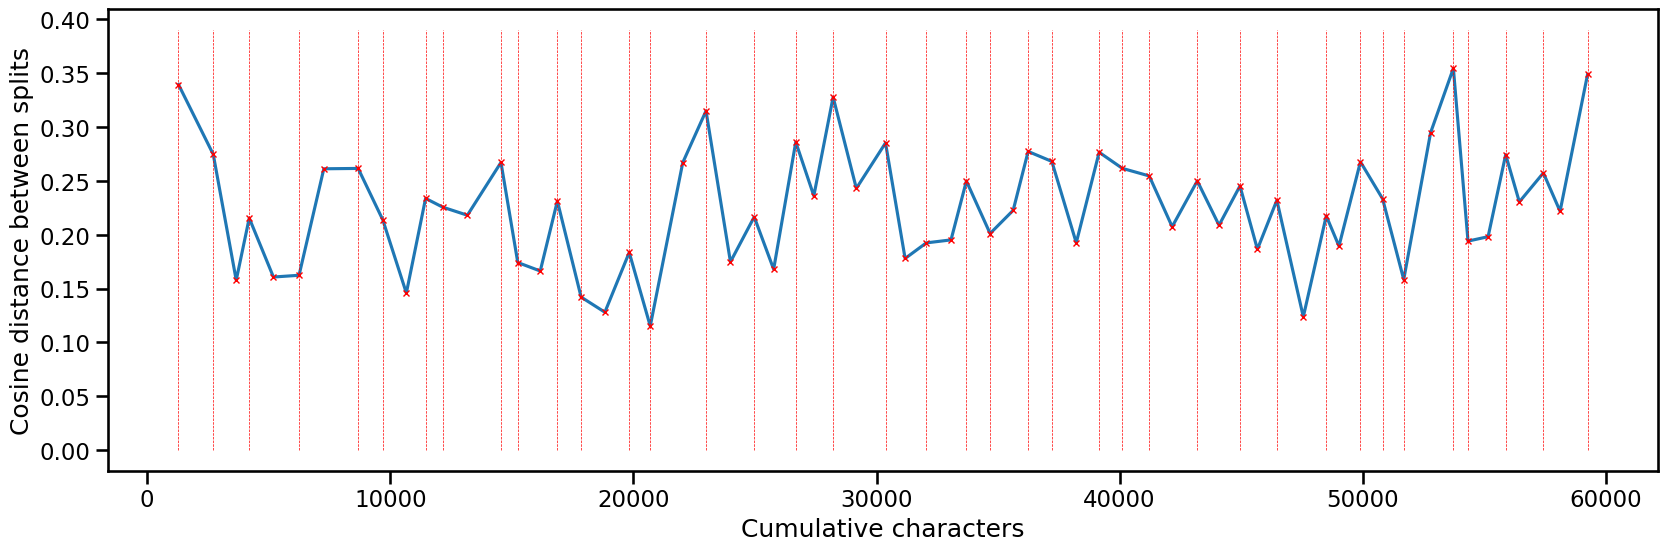

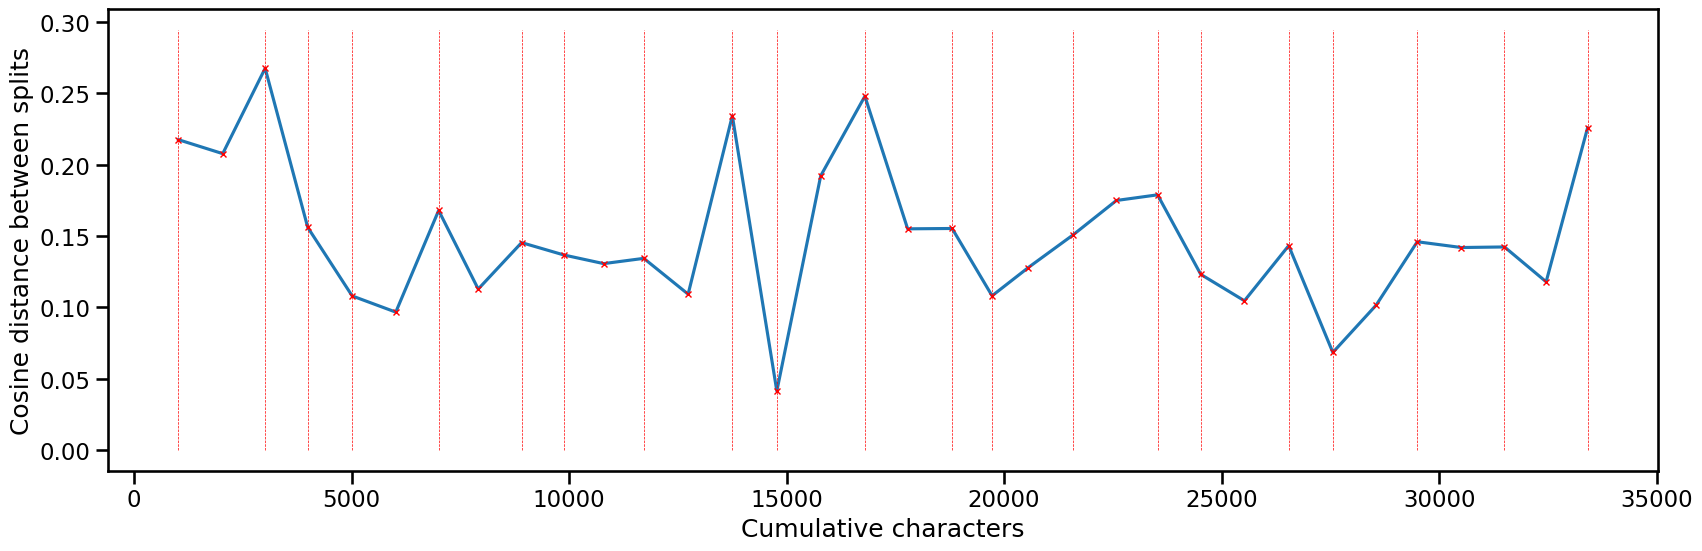

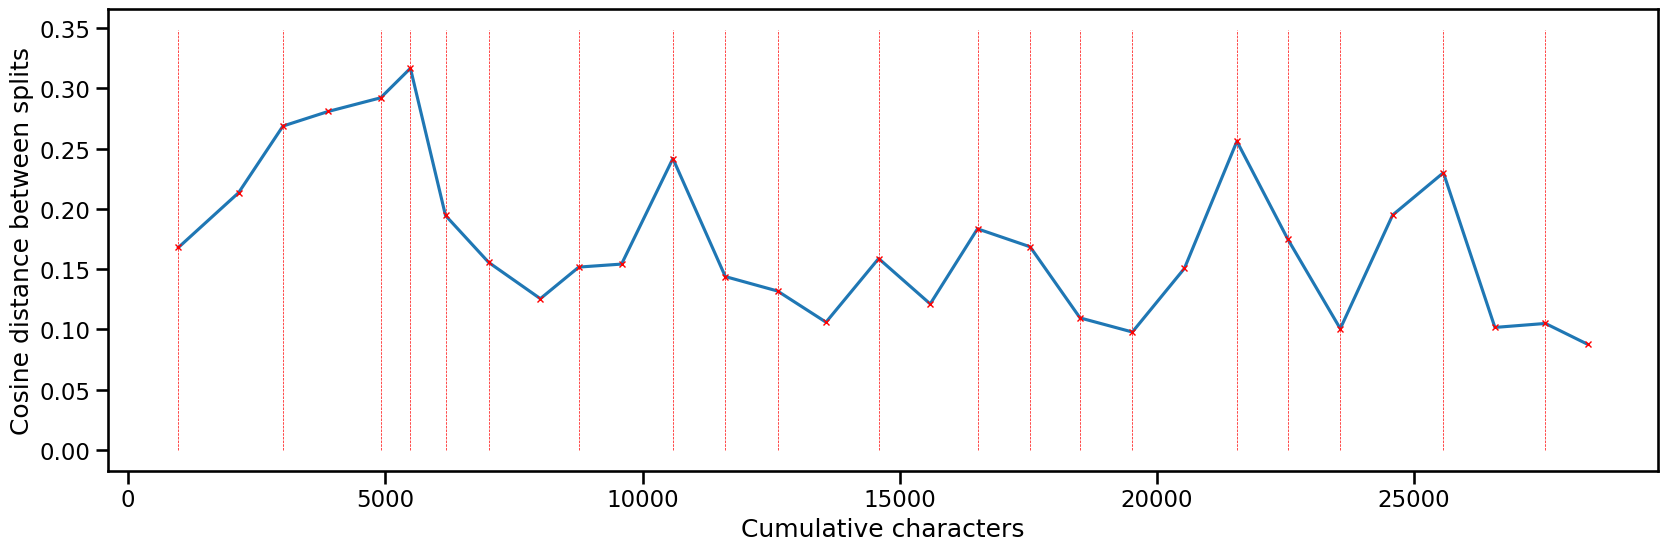

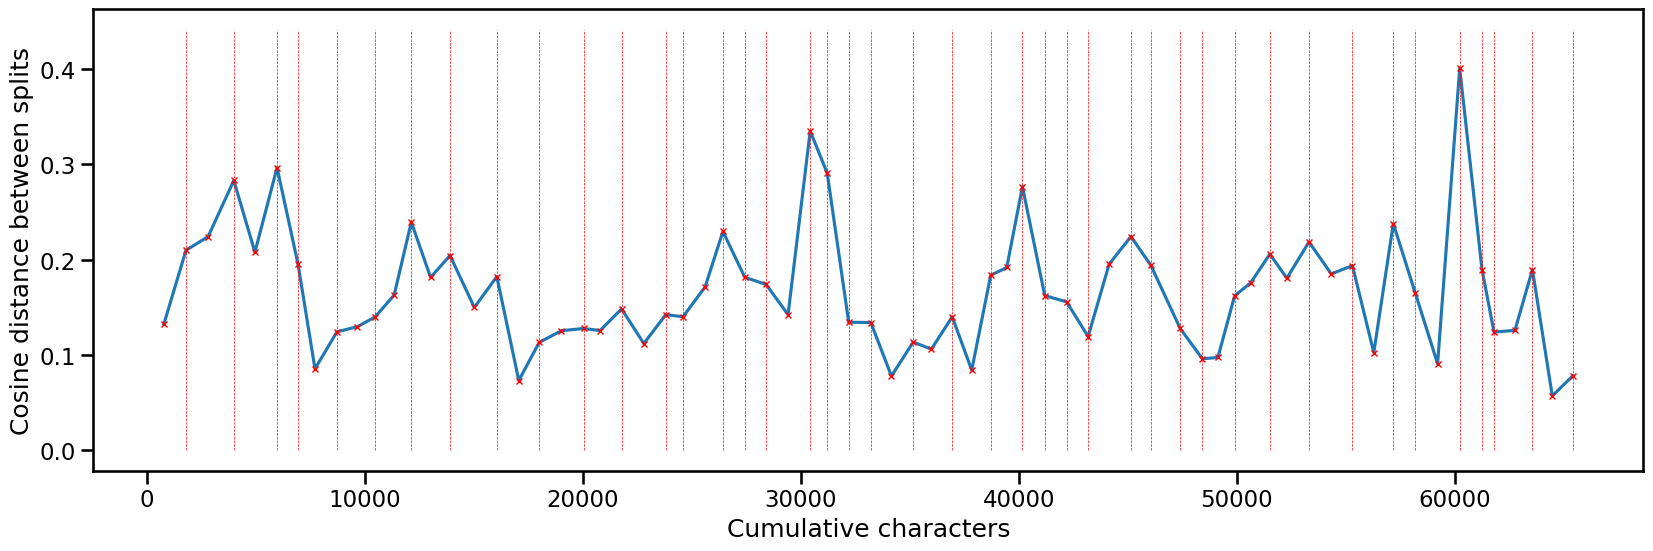

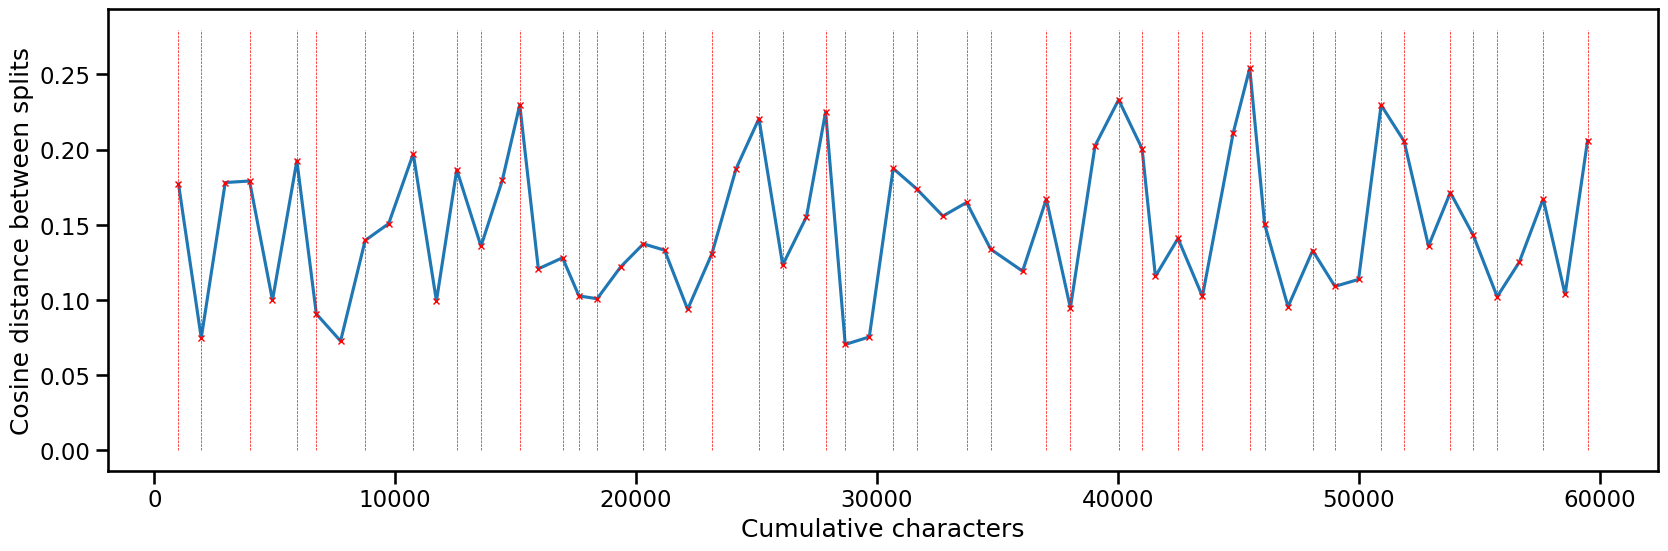

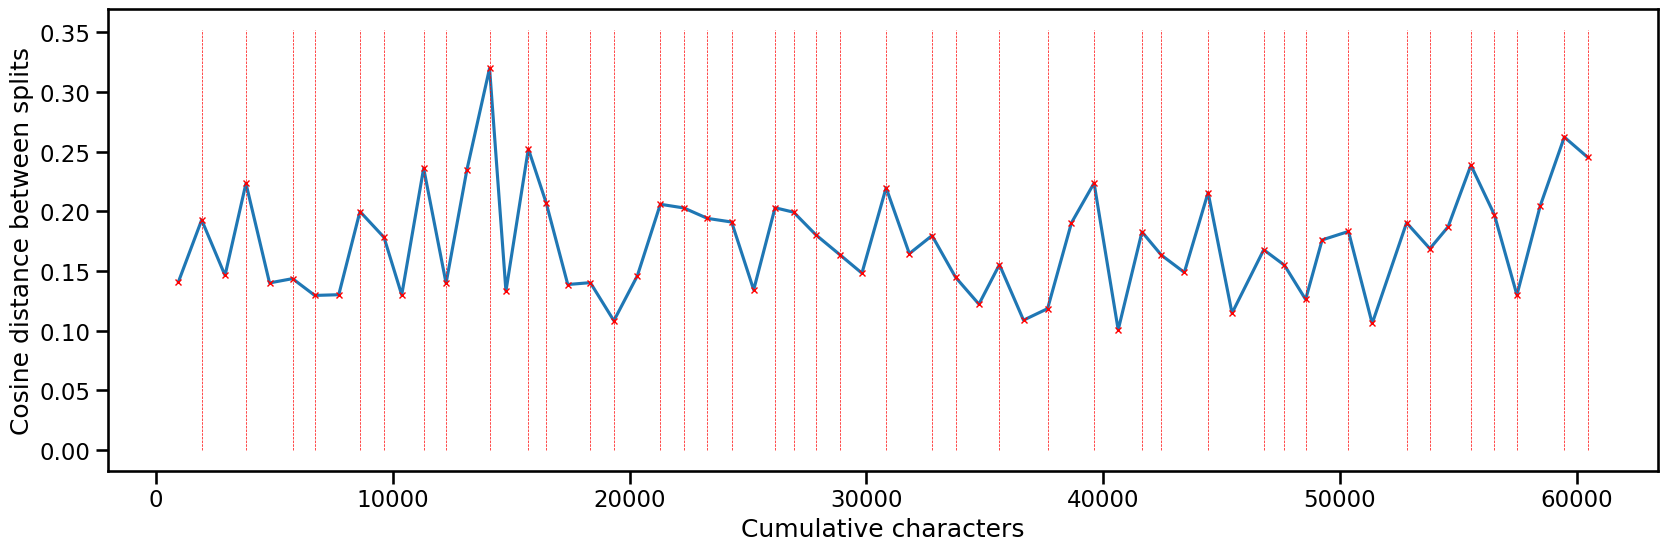

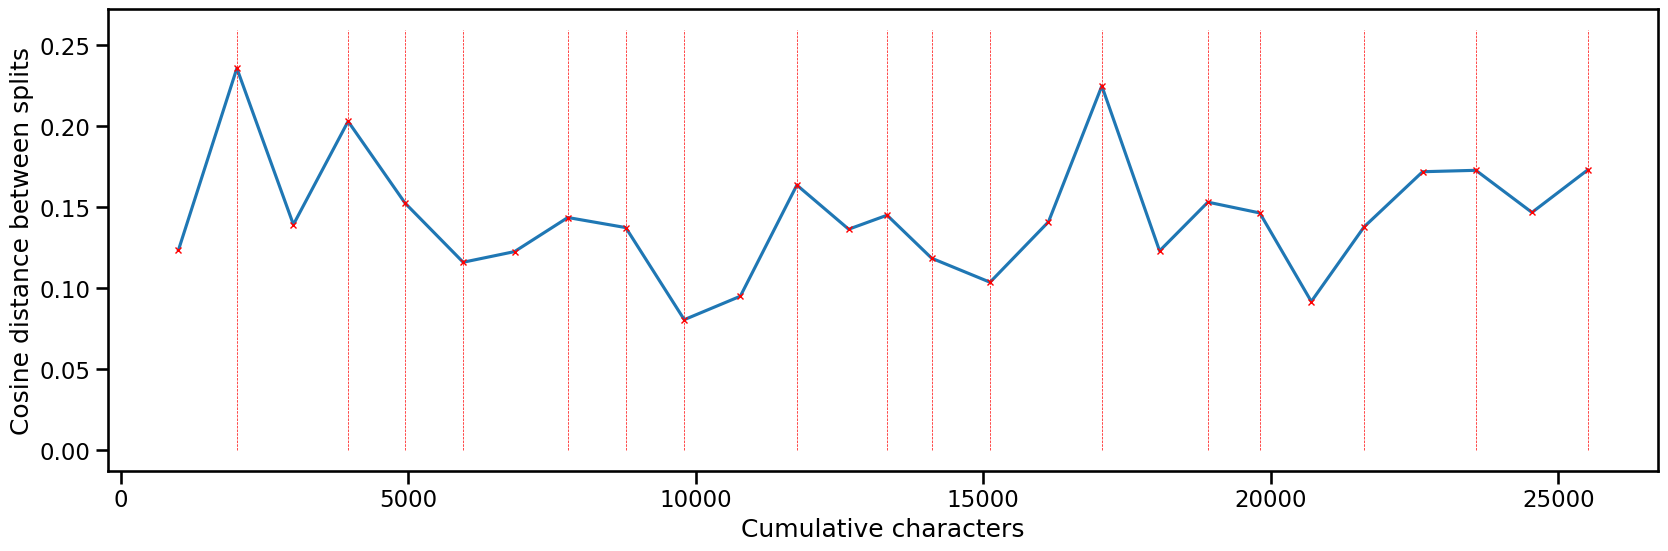

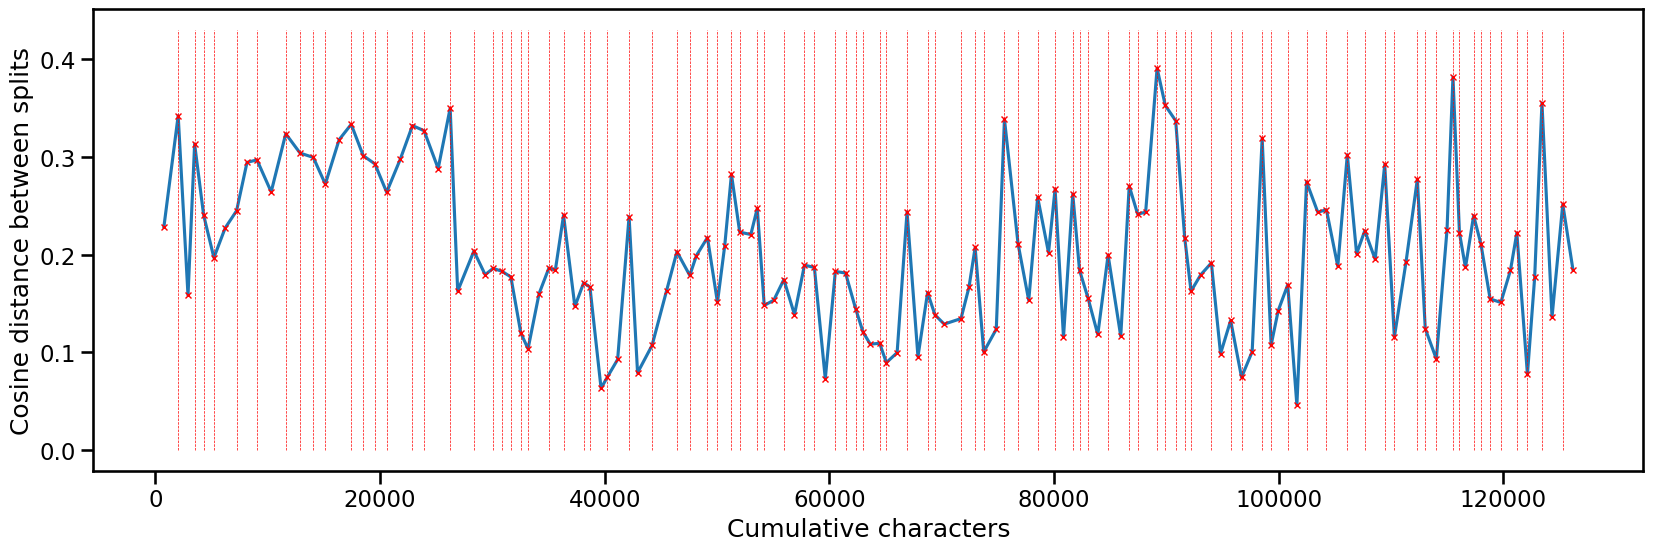

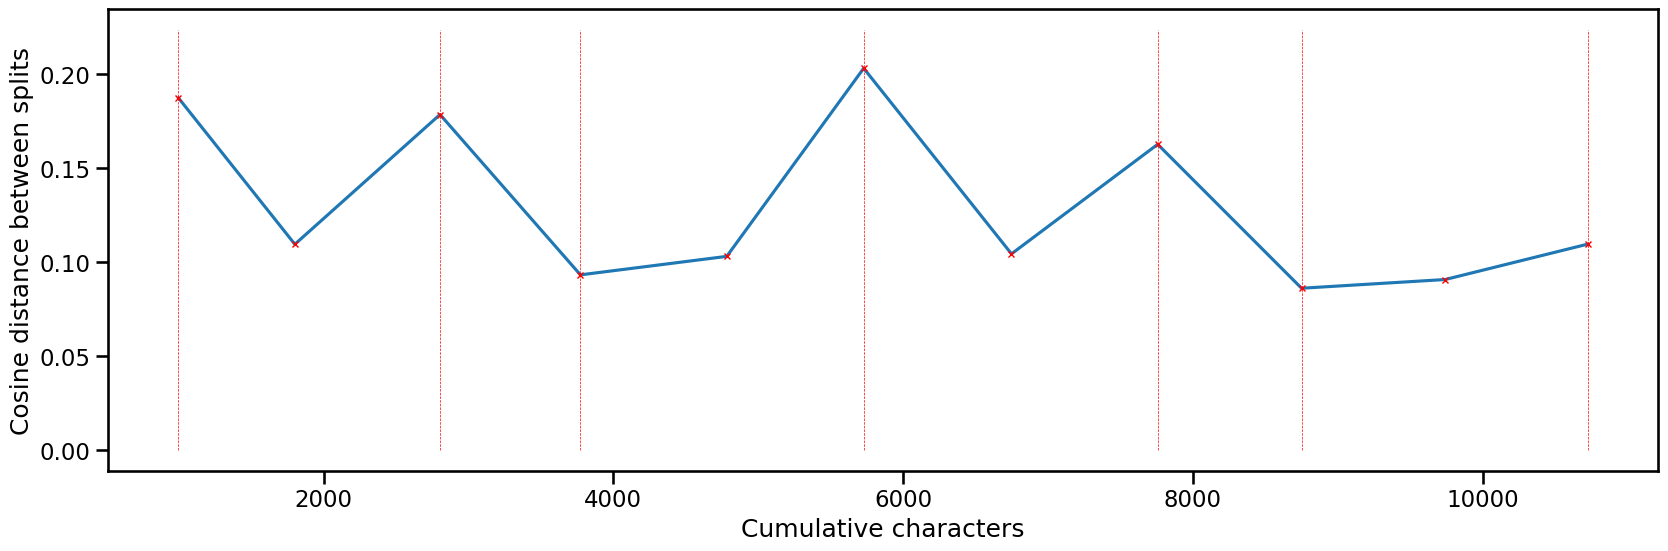

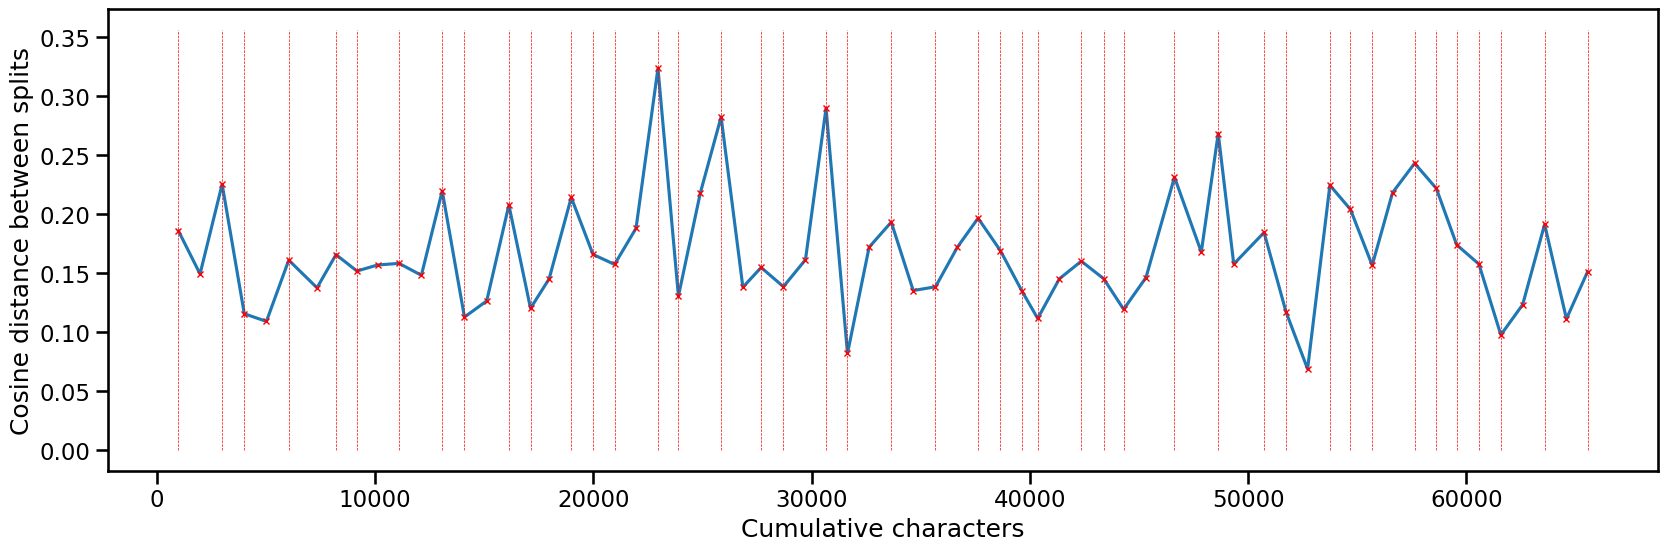

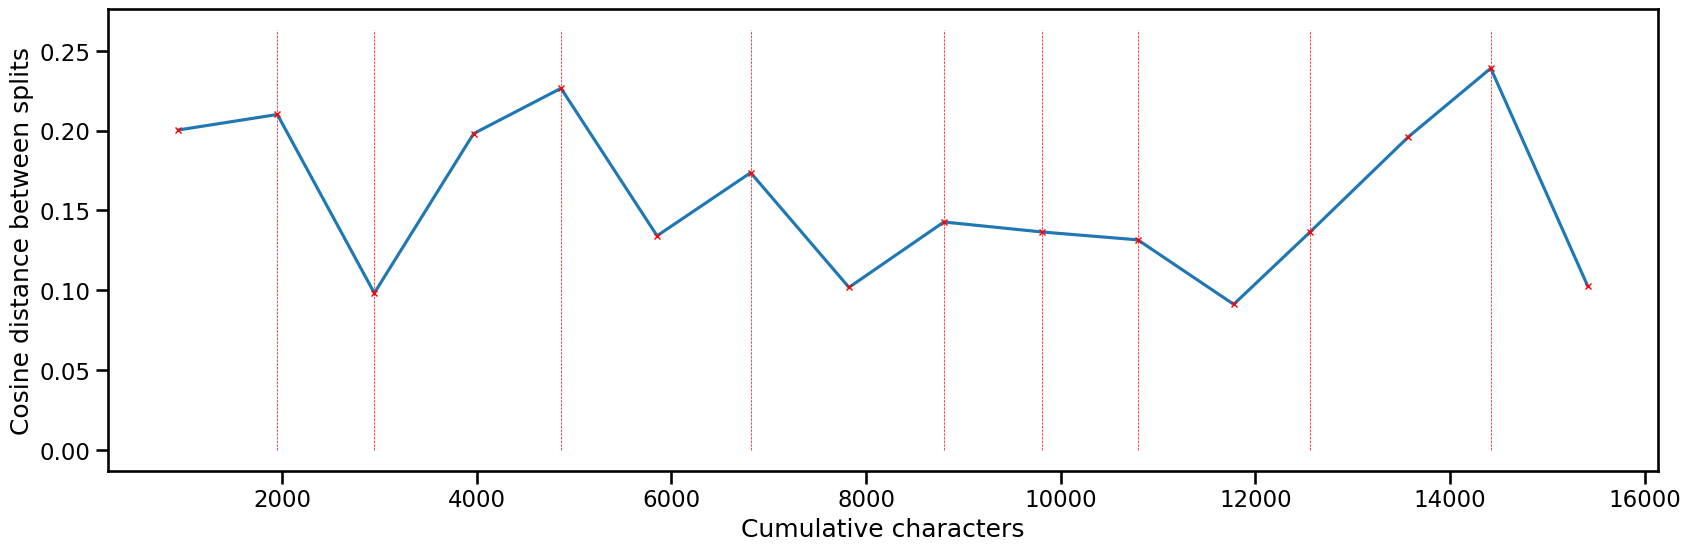

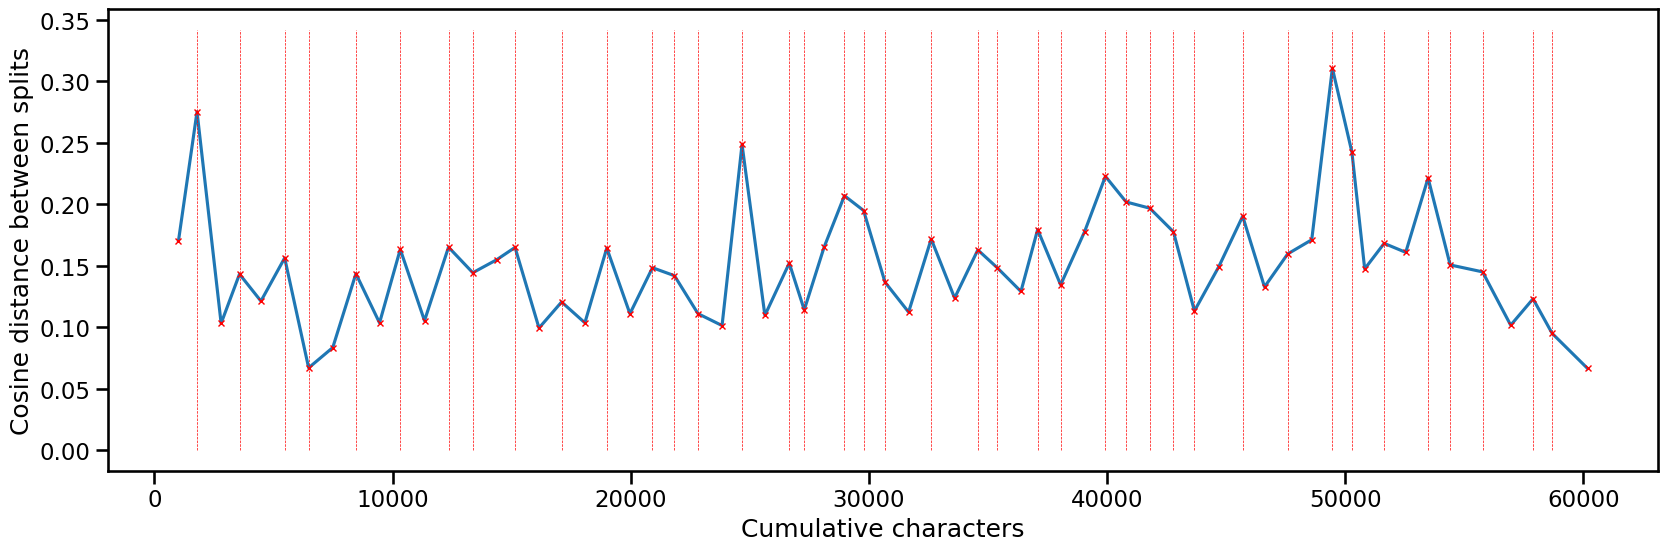

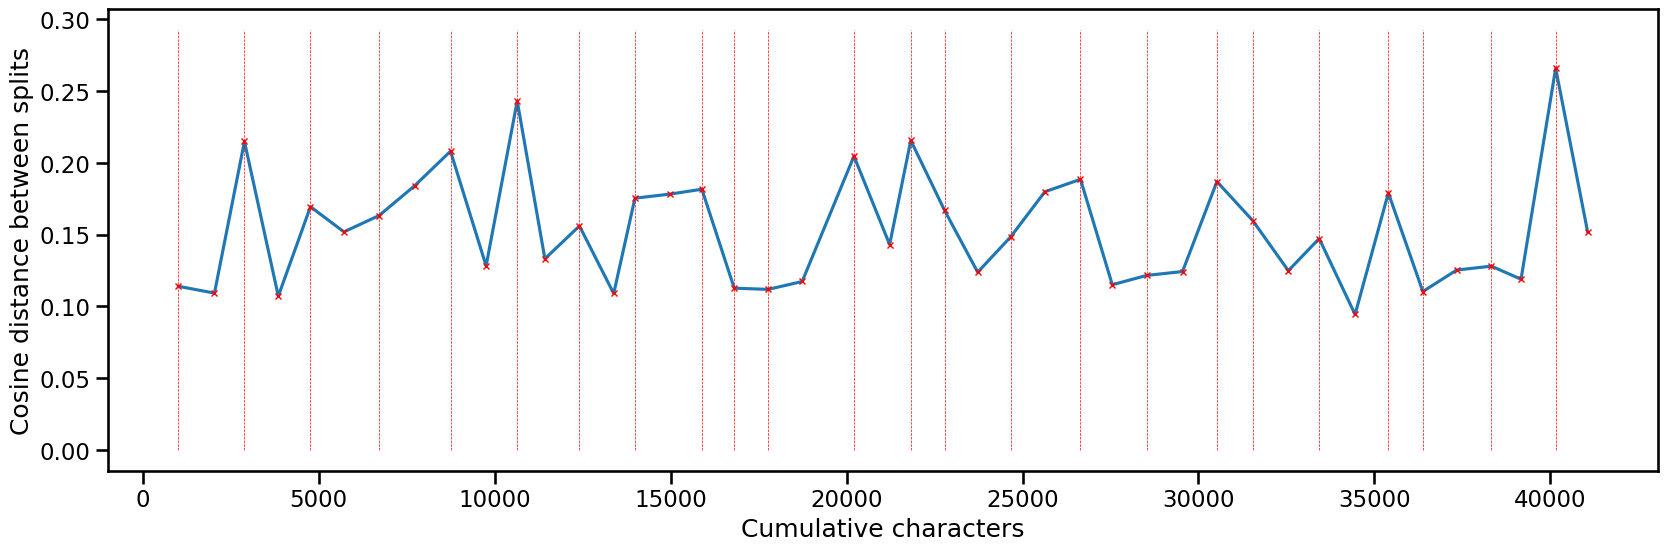

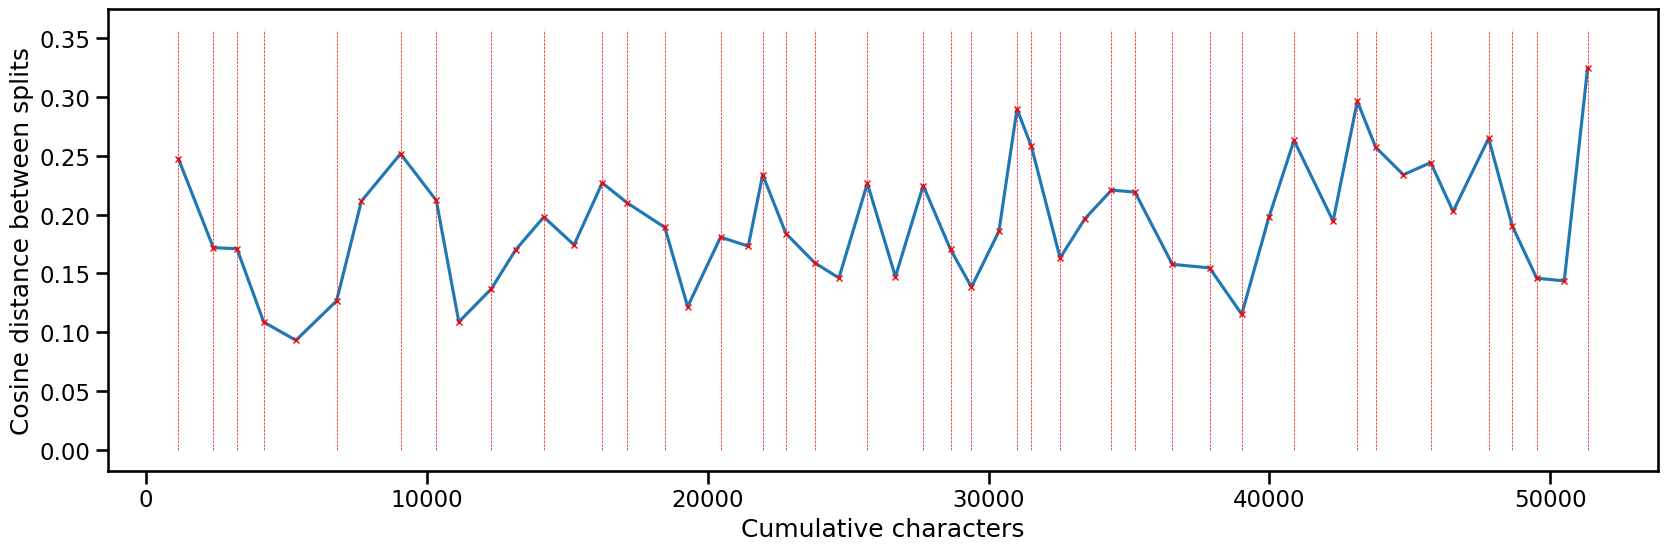

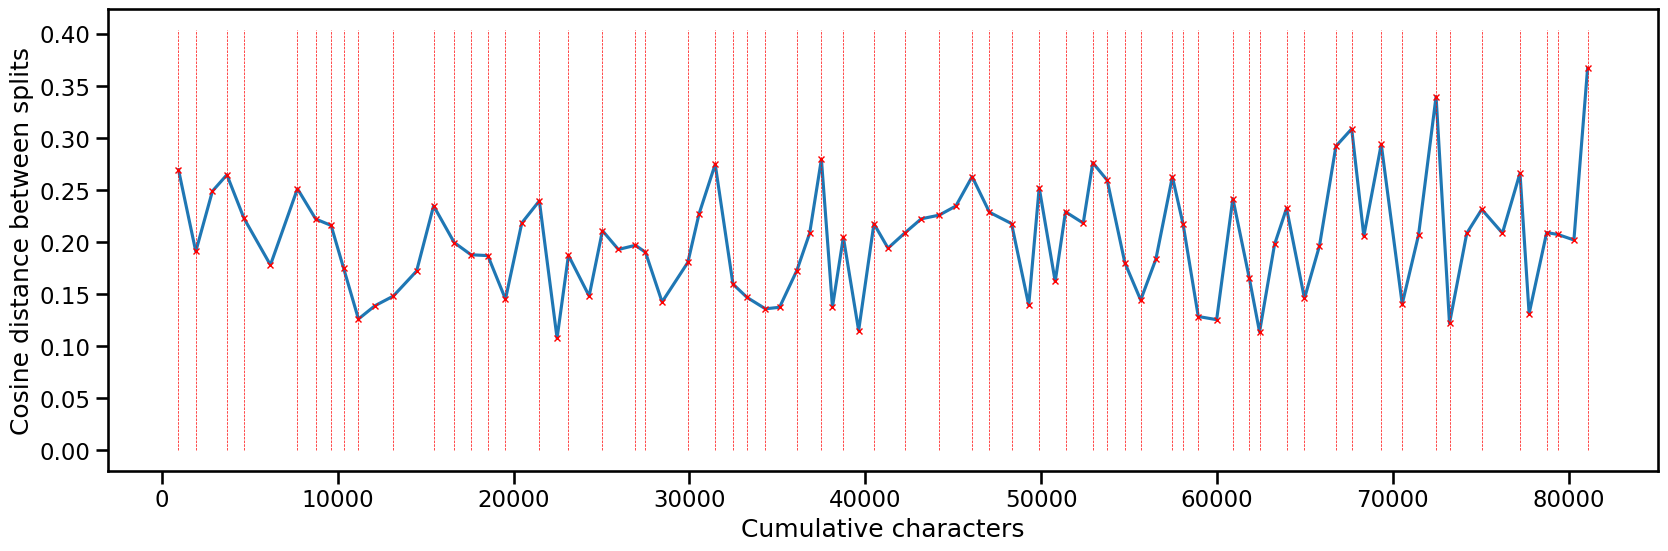

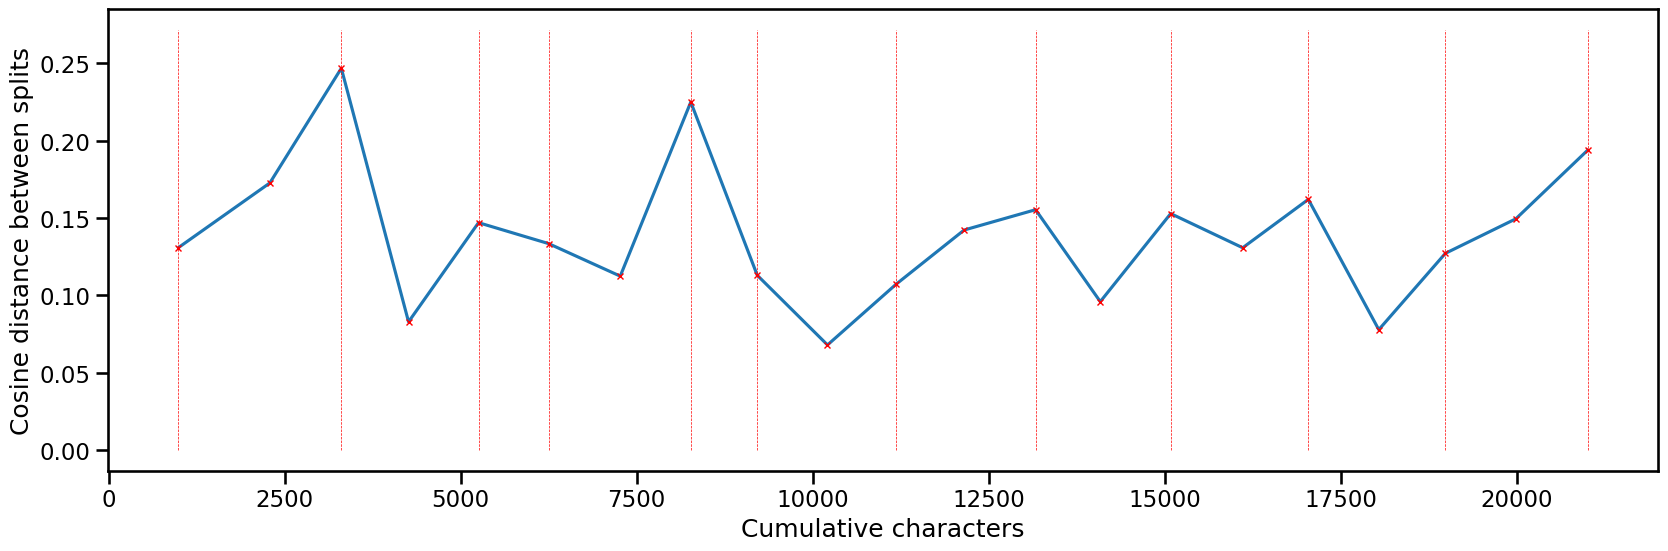

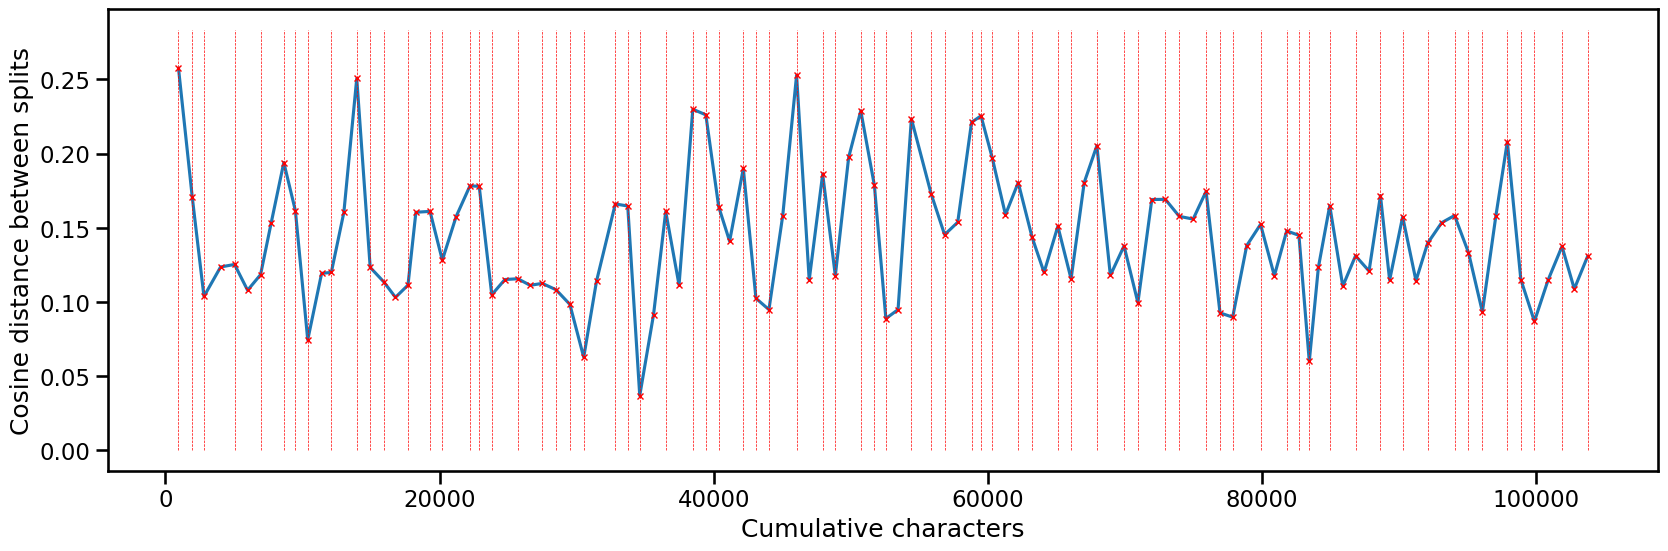

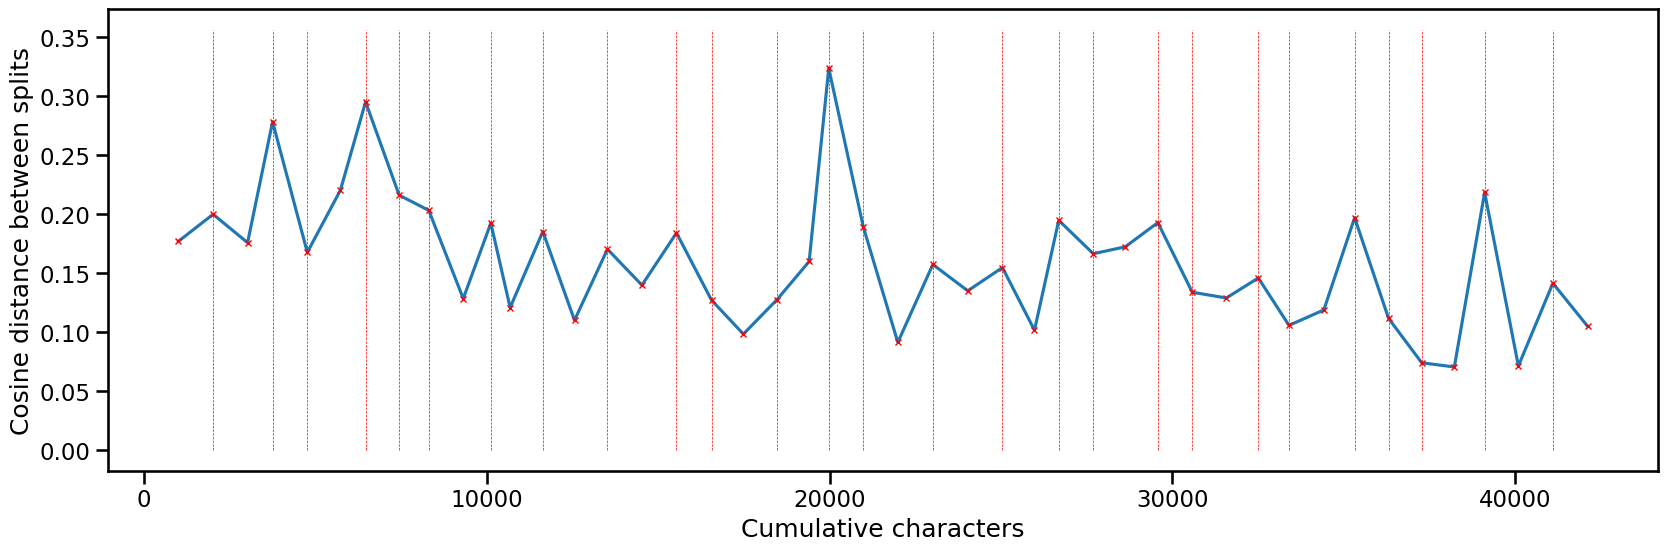

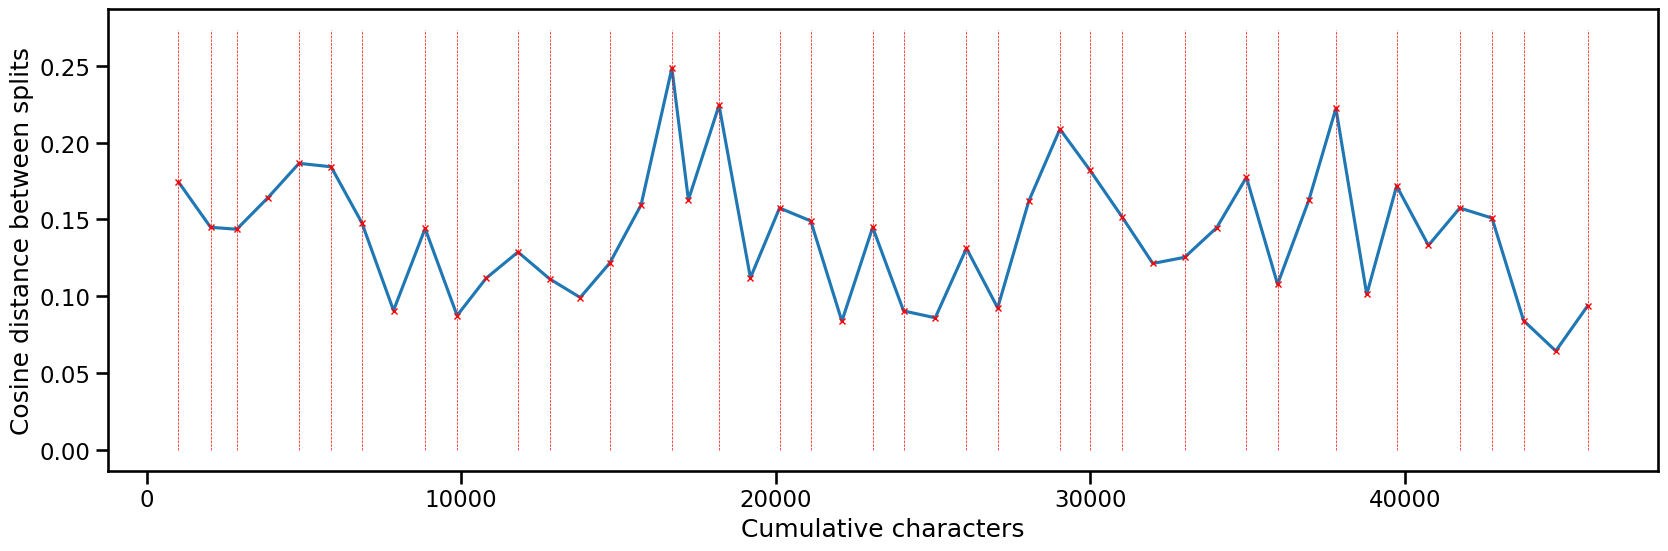

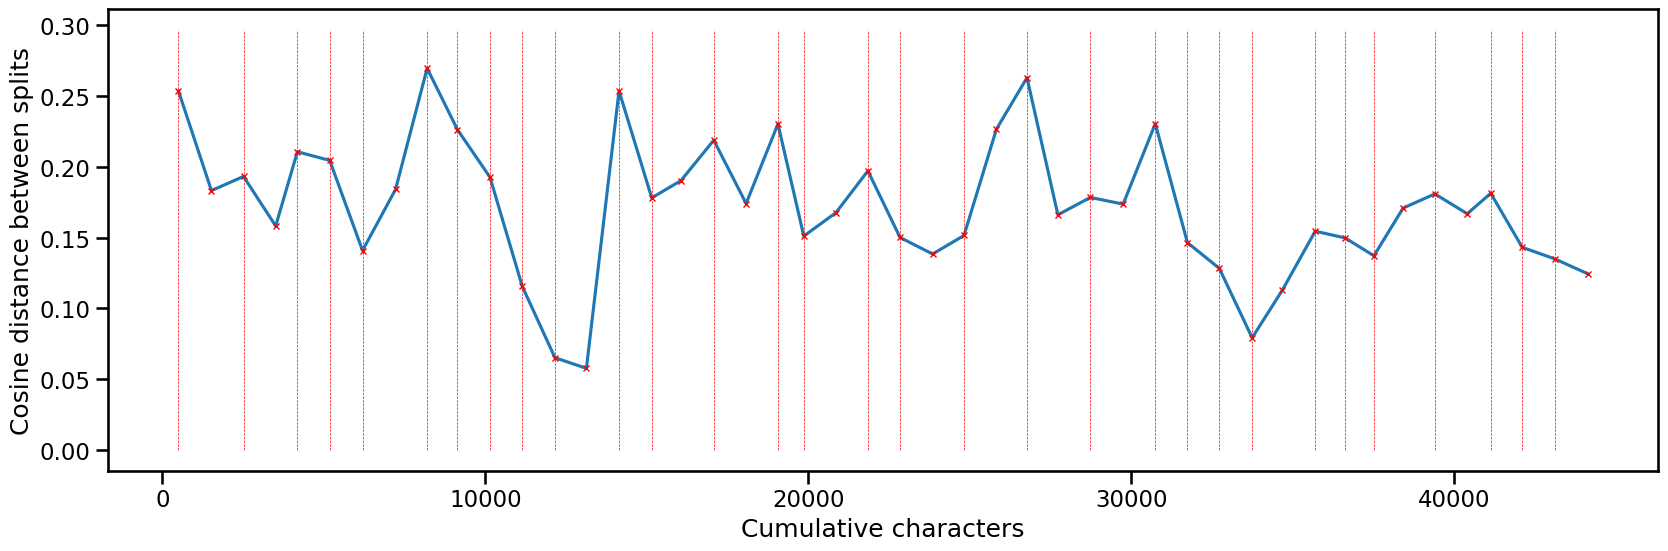

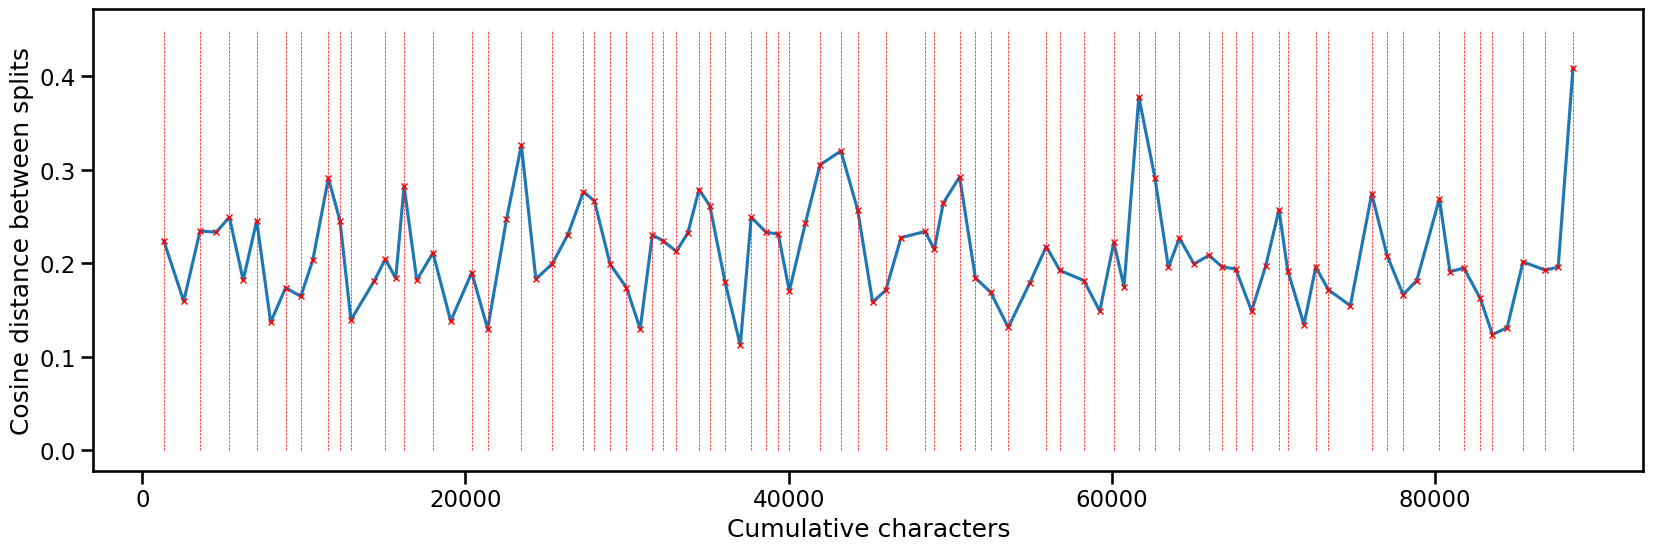

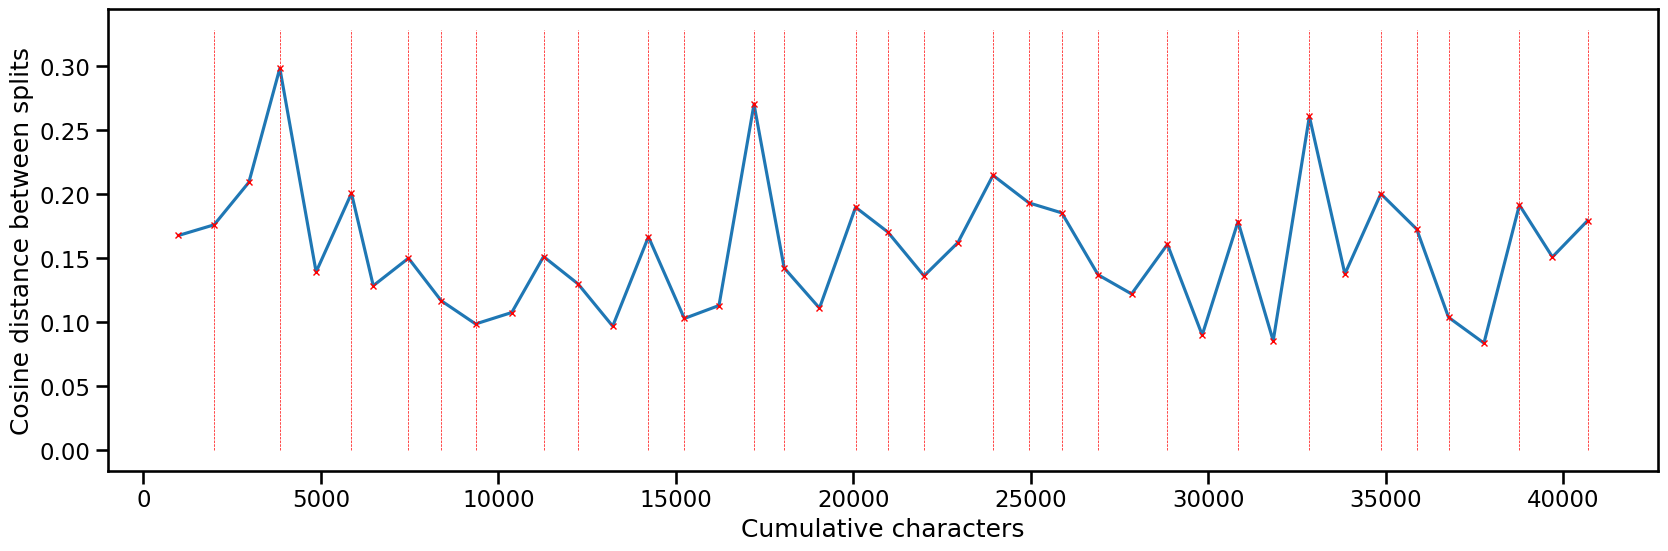

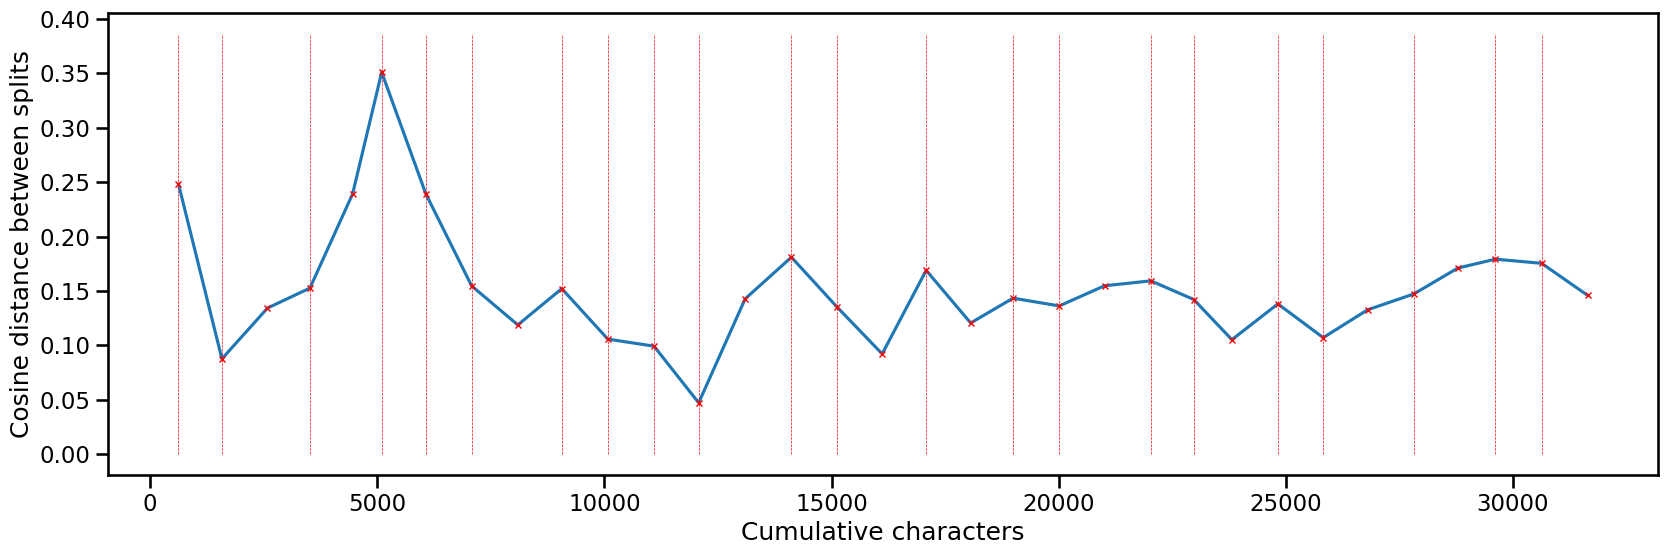

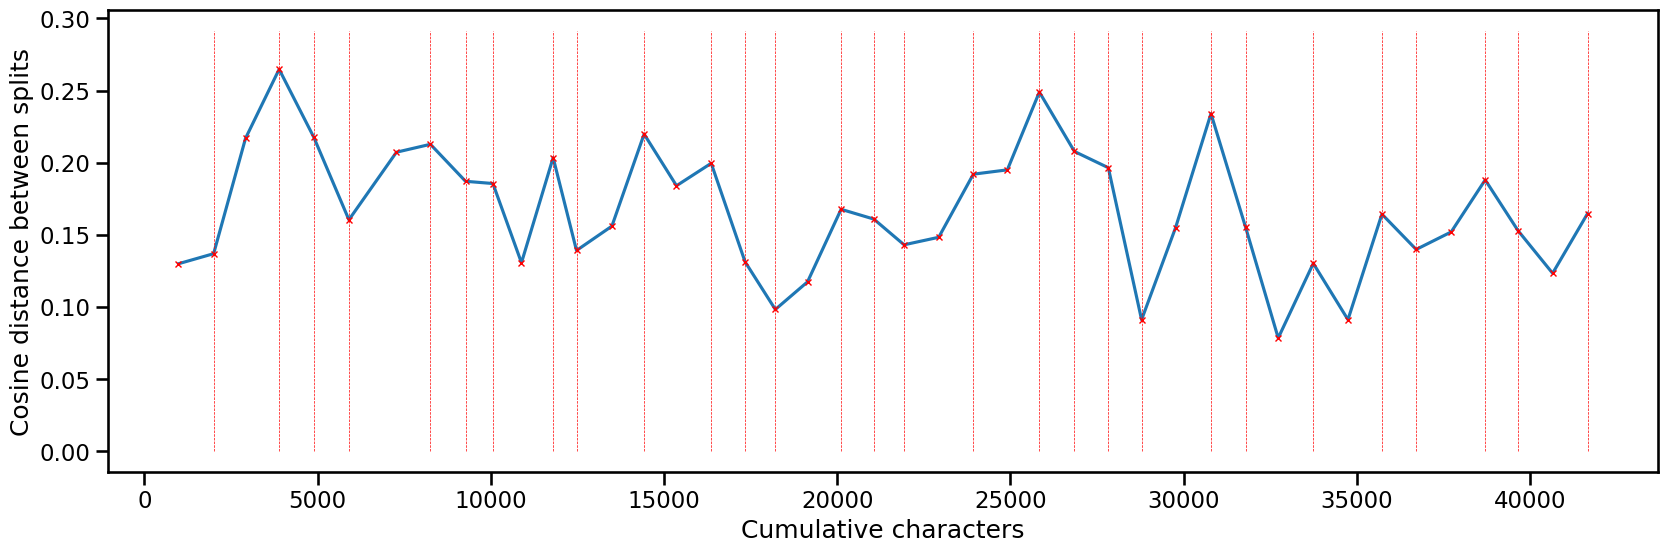

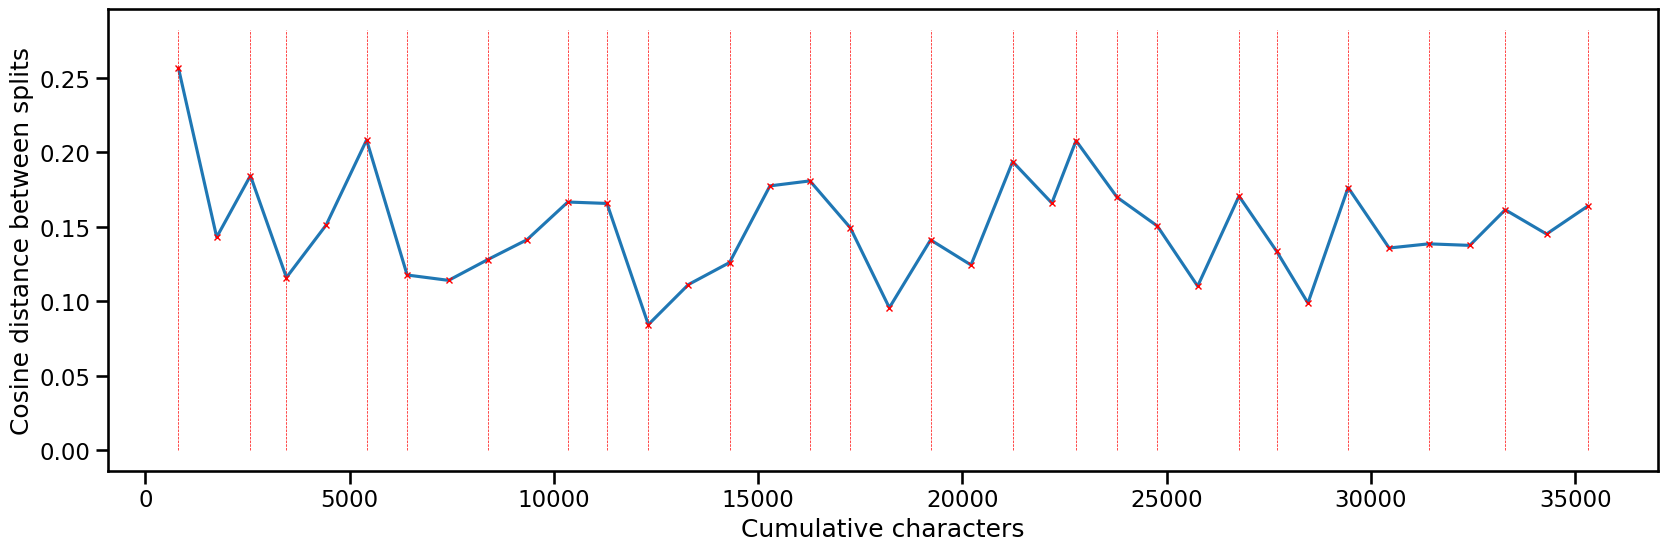

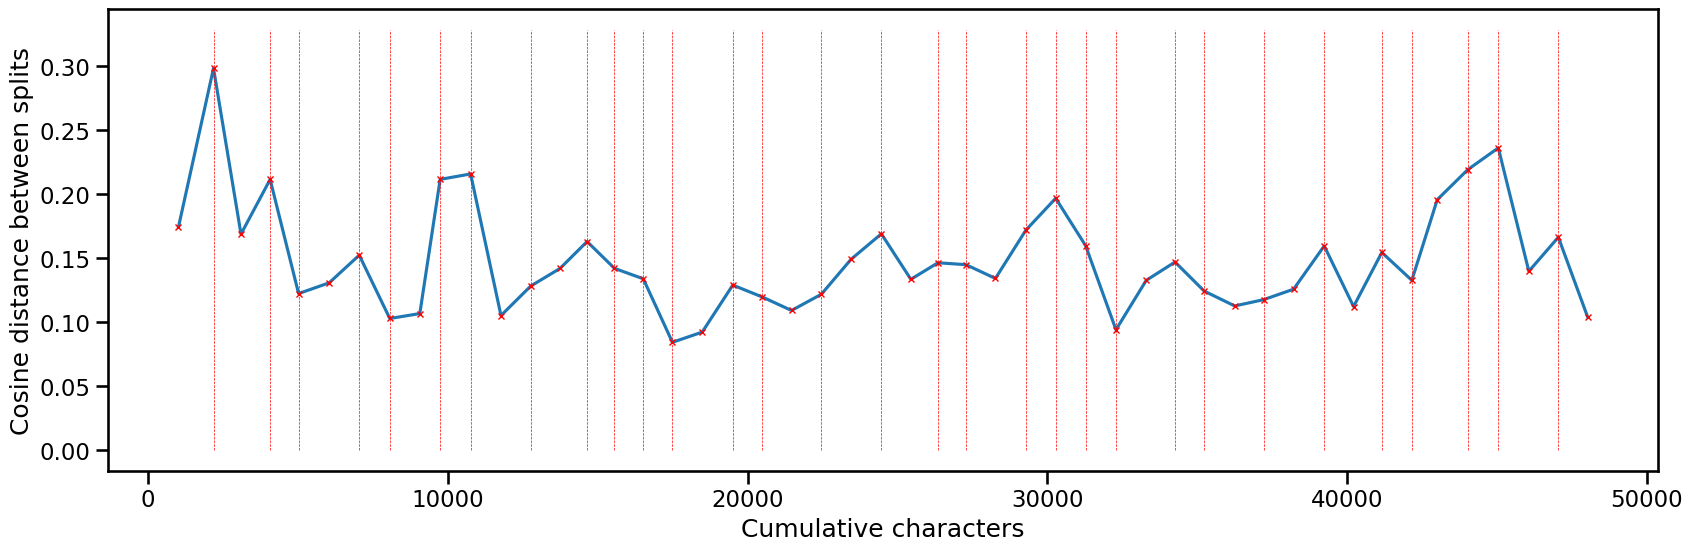

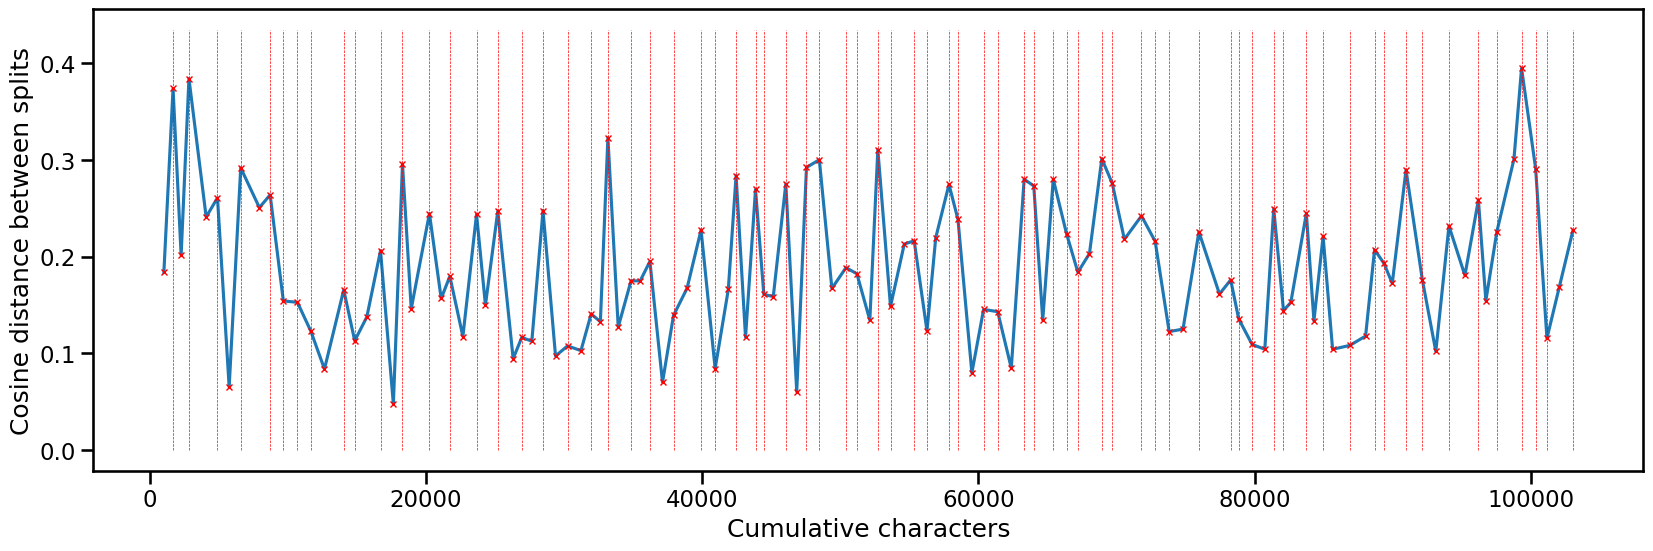

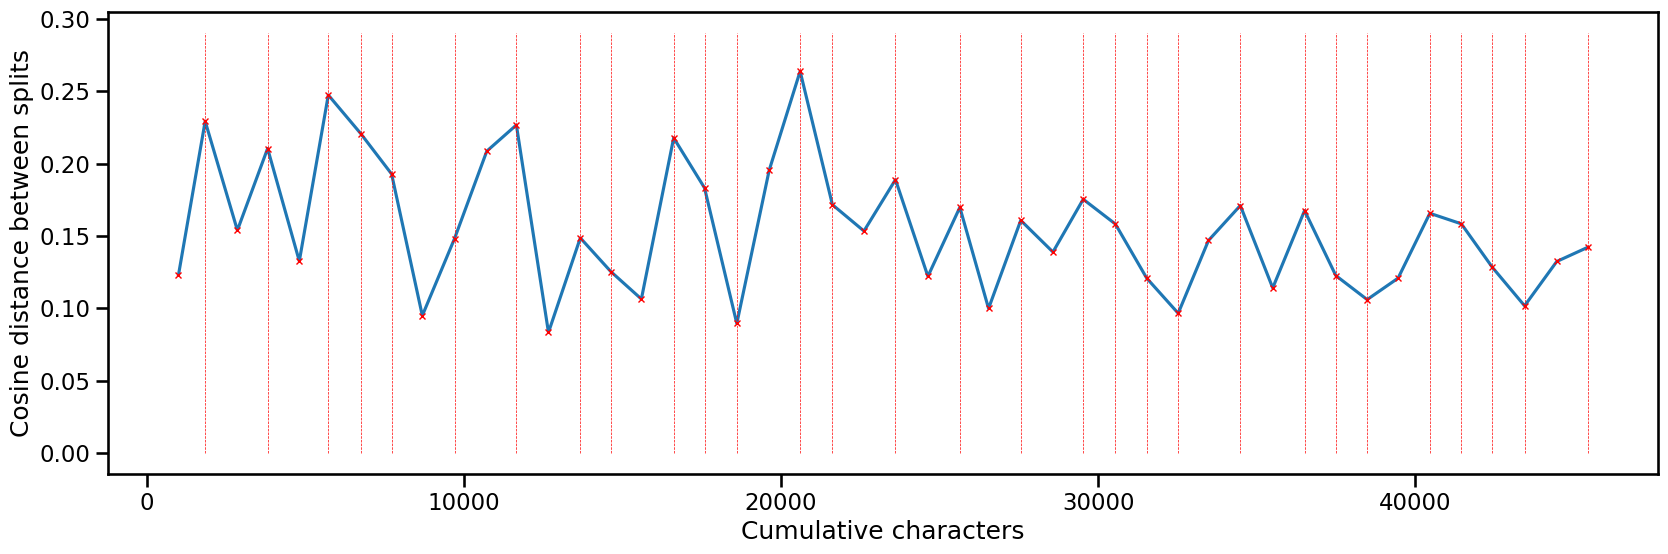

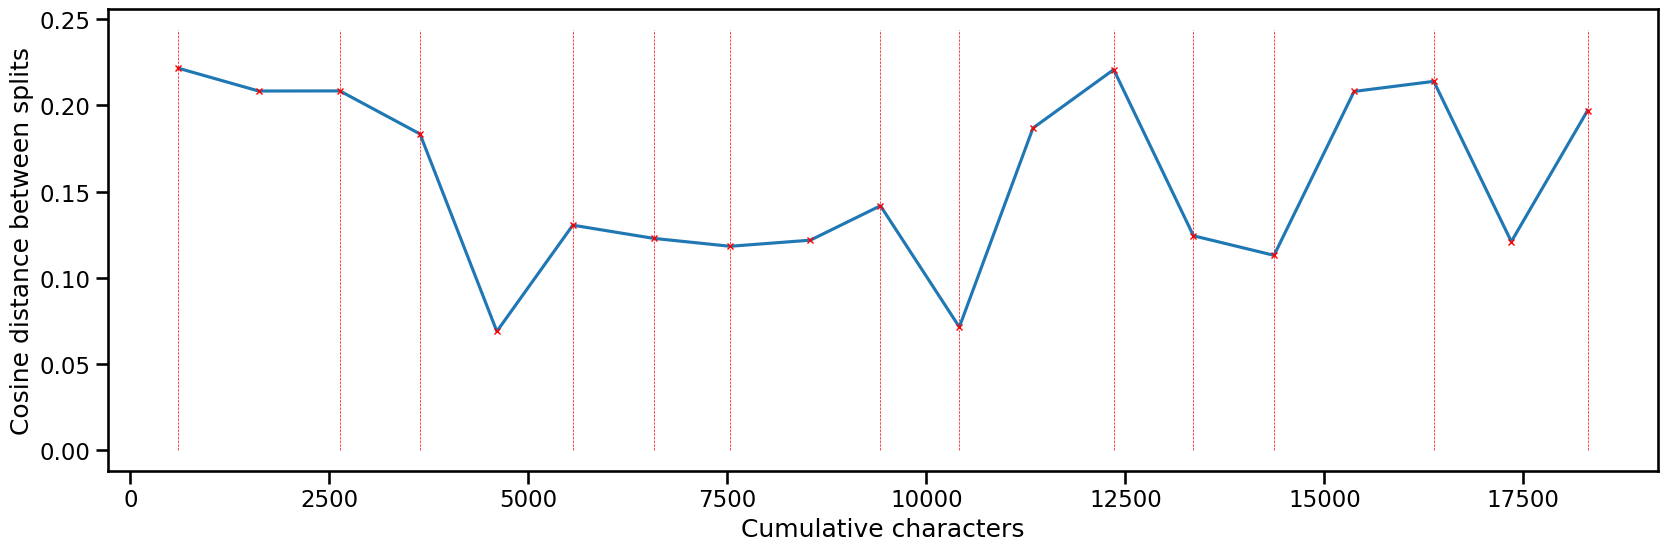

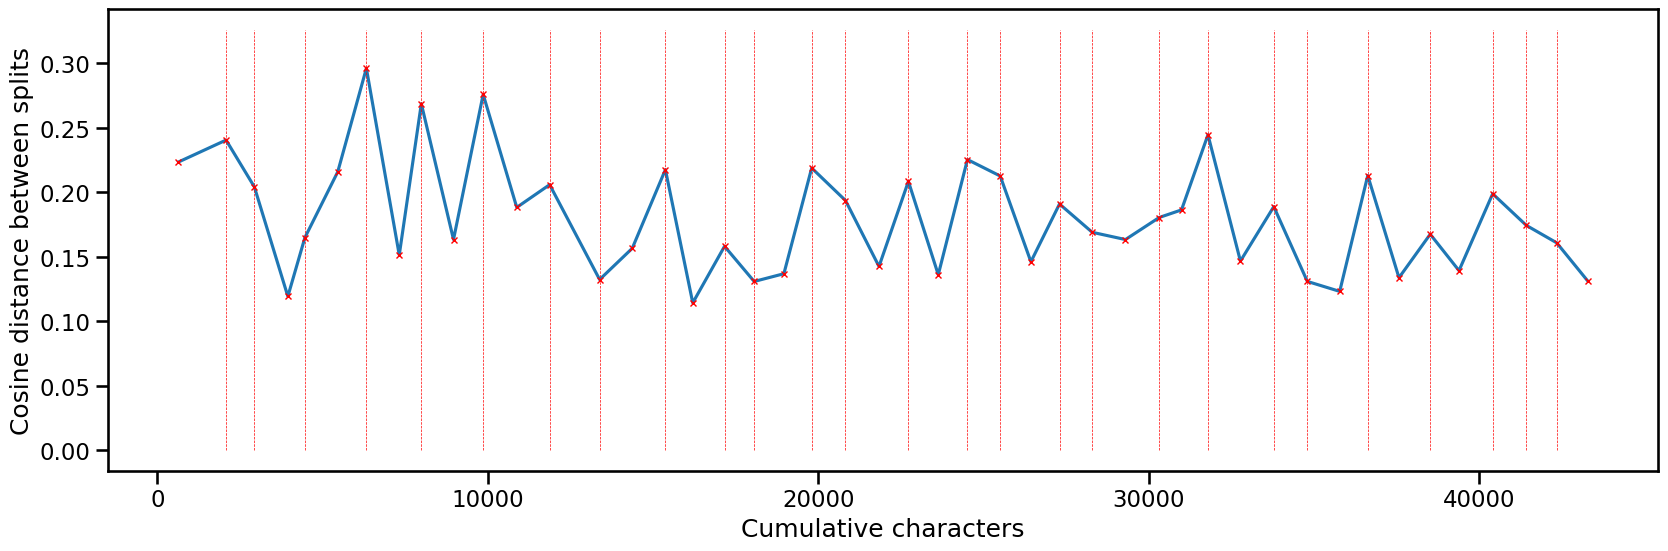

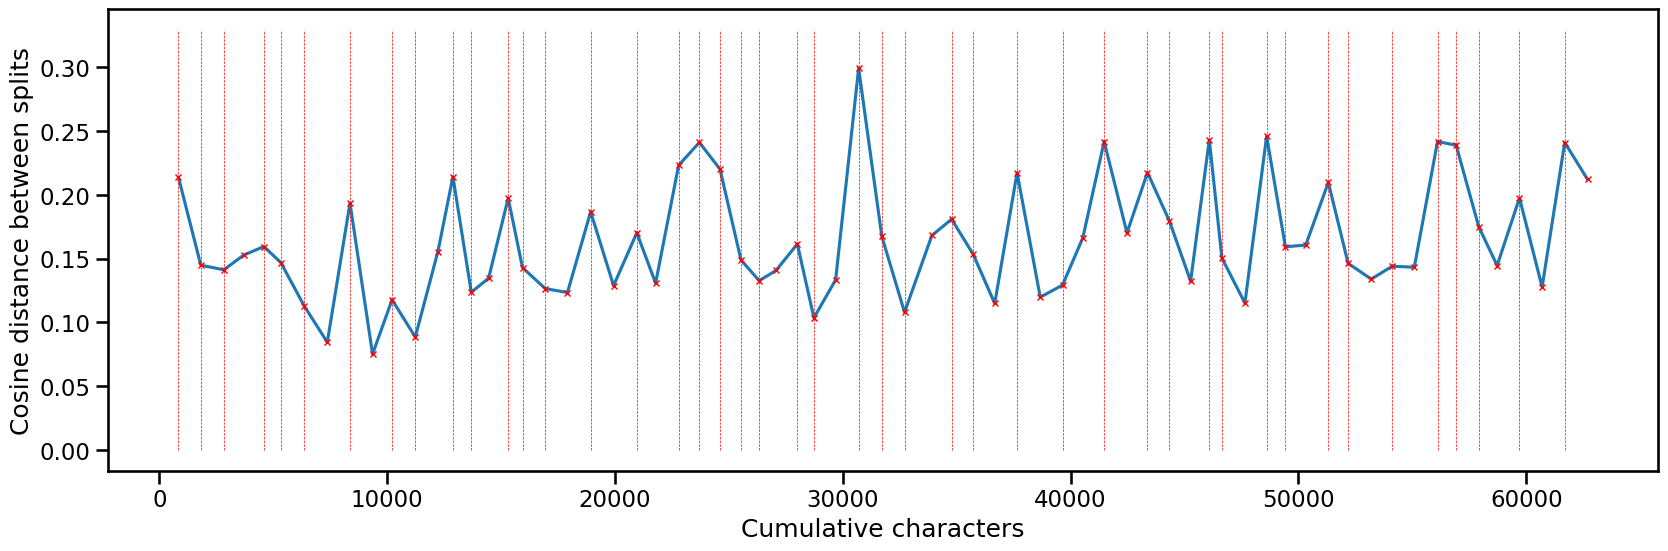

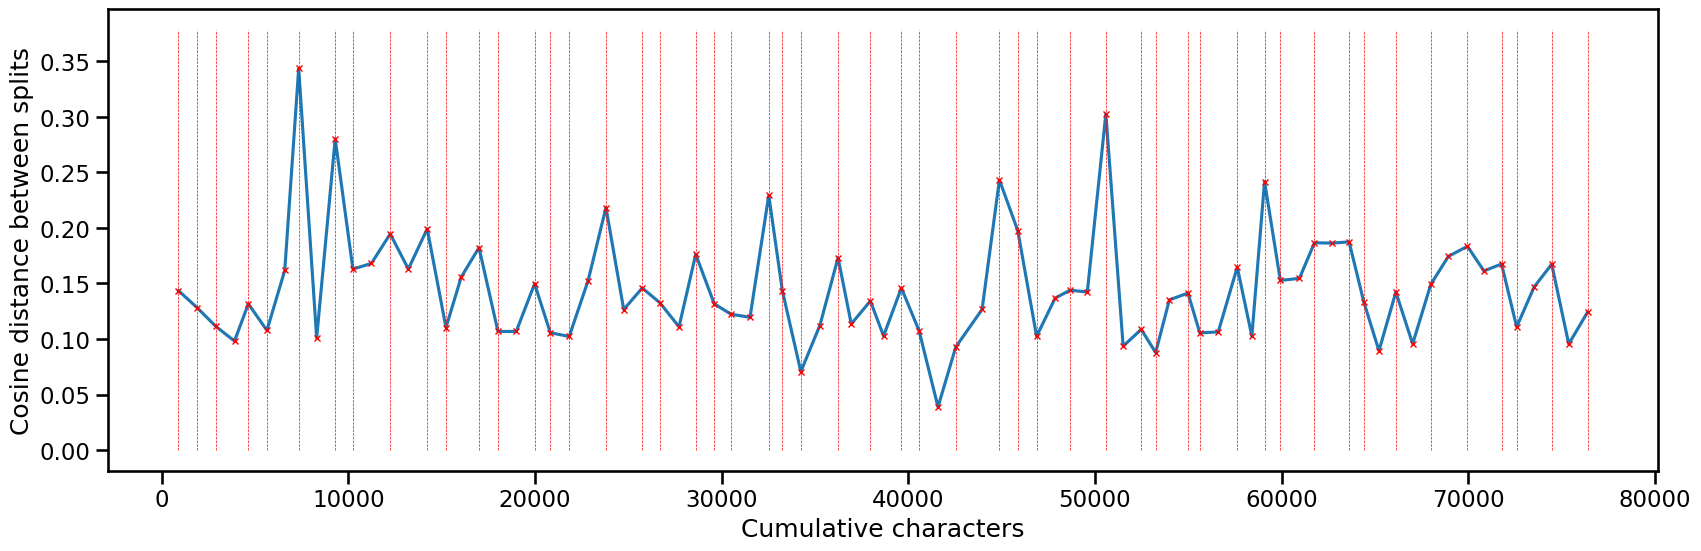

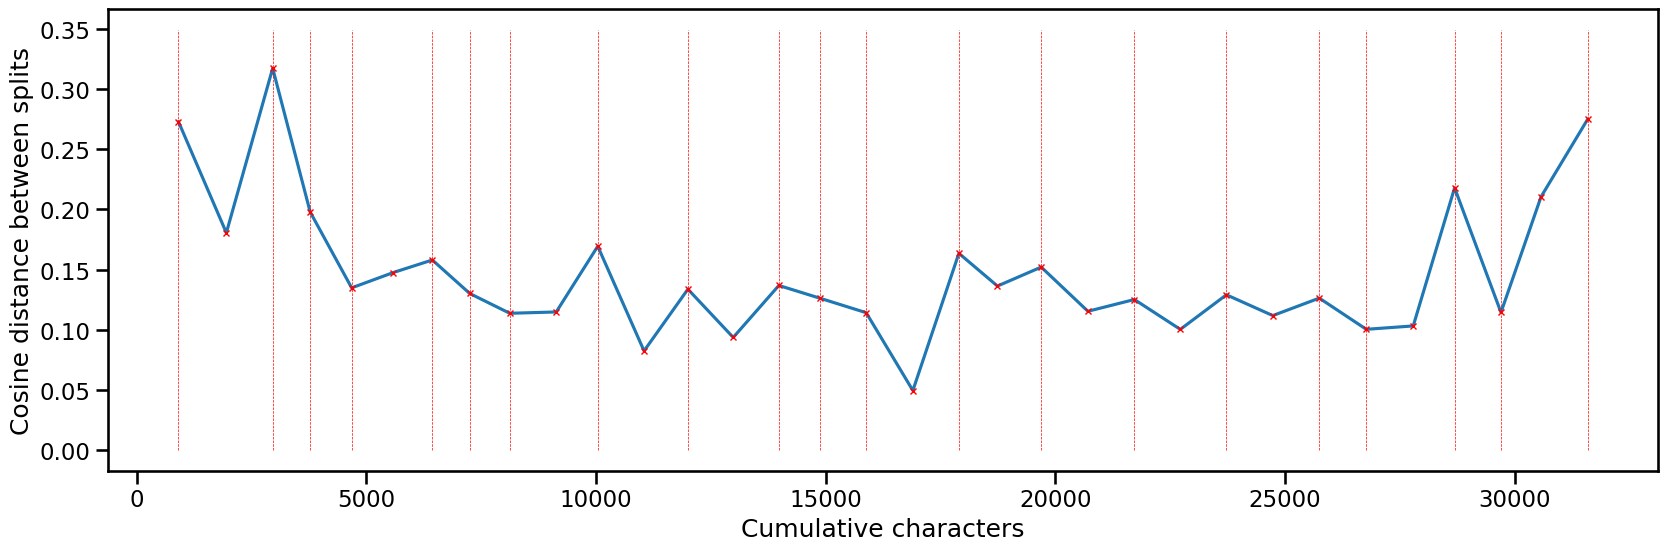

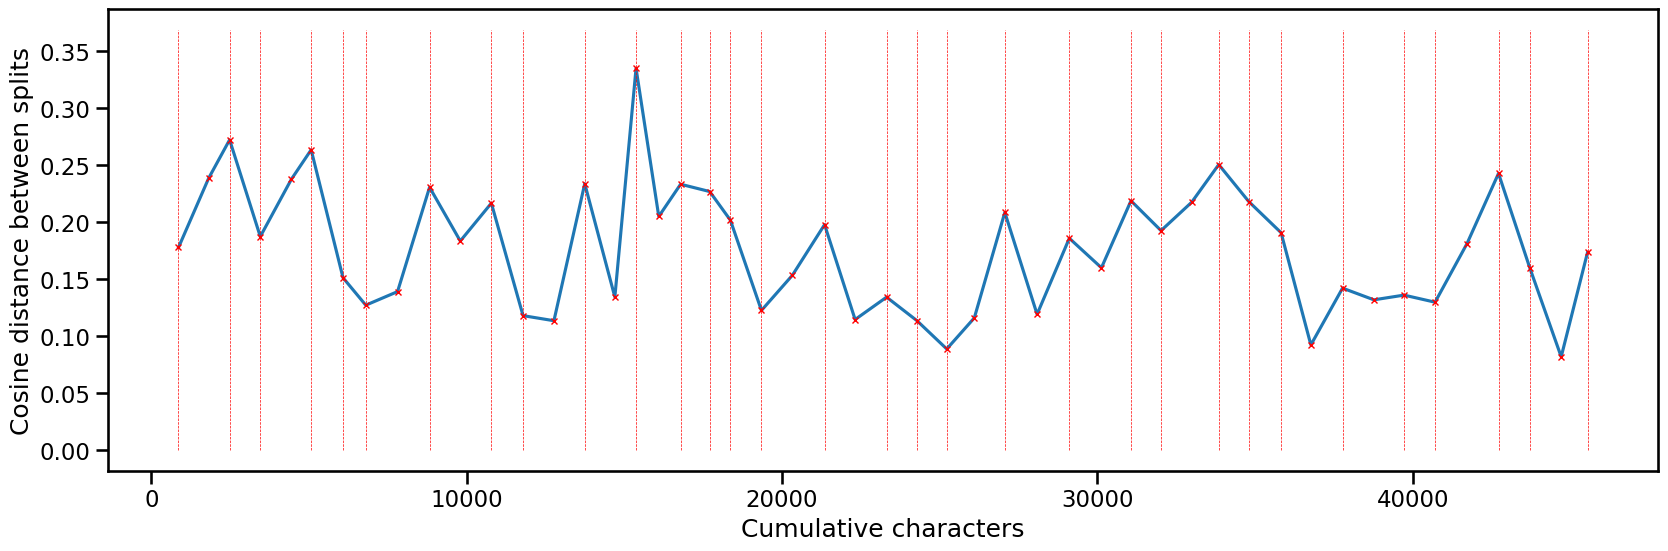

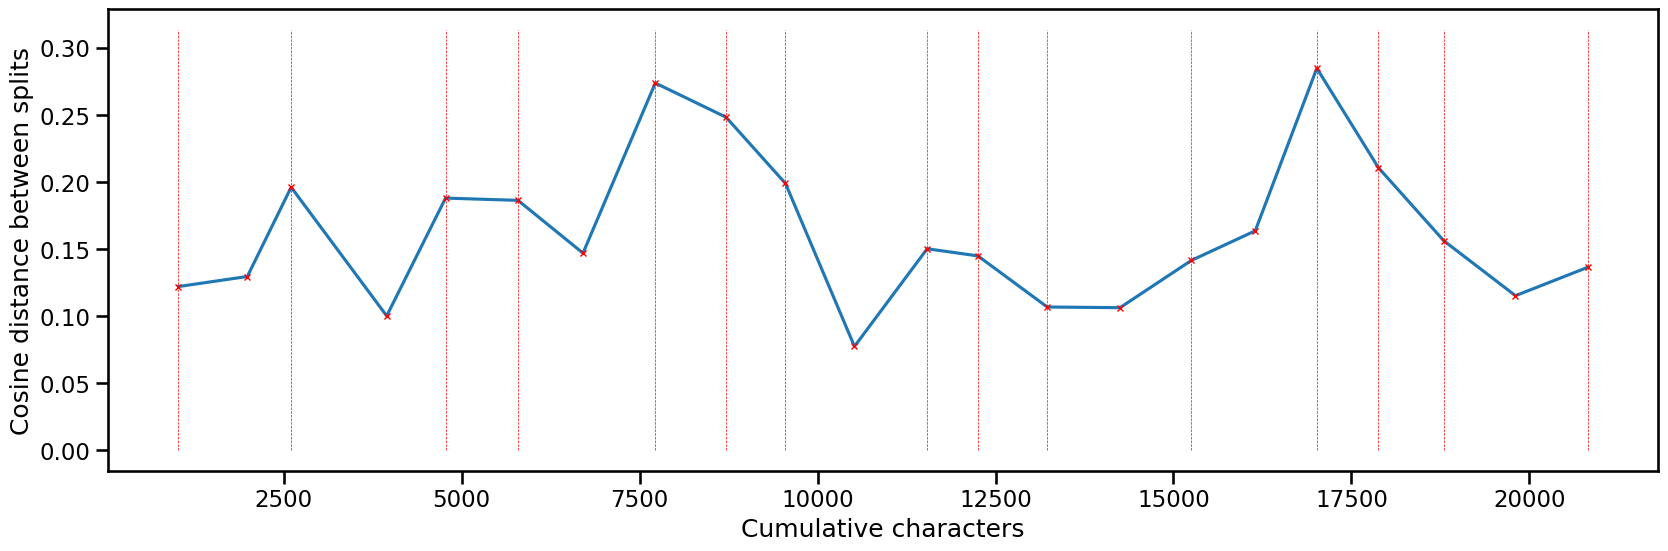

In [ ]:
breakpoints_lst, semantic_groups_lst = [], []
for original_split_texts in tqdm(original_split_texts_lst):

  original_split_text_embeddings = semantic_chunker.embed_original_document_splits(original_split_texts)
  breakpoints, semantic_groups = semantic_chunker.generate_breakpoints(
      original_split_texts,
      original_split_text_embeddings,
      length_threshold=chunk_size,
      verbose=True
  )

  breakpoints_lst.append(breakpoints)
  semantic_groups_lst.append(semantic_groups)

In [ ]:
semantic_groups = [text.strip() for text in semantic_groups_lst[0]]
print(f"total chunk: {len(semantic_groups)}")
print(min([len(t) for t in semantic_groups]))
print(np.median([len(t) for t in semantic_groups]))
print(max([len(t) for t in semantic_groups]))

# for i, chunk in enumerate(semantic_groups):
#   print(f"Chunk {i} (len={len(chunk)}):\n")
#   print(chunk)
#   print("\n" + "="*50 + "\n")

total chunk: 40
602
1551.0
2432


In [ ]:
def lcs_lines(retrieved_lines, relevant_lines):
    """
    Computes both the length and the actual Longest Common Subsequence (LCS) as a list of lines
    between two lists of lines (retrieved_lines and relevant_lines).

    Parameters:
        retrieved_lines (list of str): The retrieved lines.
        relevant_lines (list of str): The ground truth lines.

    Returns:
        tuple: (lcs_length, lcs_sequence) where lcs_length is an integer and lcs_sequence is a list of lines.
    """
    m = len(retrieved_lines)
    n = len(relevant_lines)

    # Build DP table (dimensions: (m+1) x (n+1)) for LCS lengths
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    # Populate the DP table
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if retrieved_lines[i - 1] == relevant_lines[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

    # Backtracking to reconstruct the LCS sequence from the DP table
    lcs_sequence = []
    i, j = m, n
    while i > 0 and j > 0:
        if retrieved_lines[i - 1] == relevant_lines[j - 1]:
            # When there's a match, it belongs to the LCS.
            lcs_sequence.append(retrieved_lines[i - 1])
            i -= 1
            j -= 1
        elif dp[i - 1][j] >= dp[i][j - 1]:
            i -= 1
        else:
            j -= 1

    # Reverse the sequence because we built it backwards
    lcs_sequence.reverse()
    lcs_length = dp[m][n]

    return lcs_length, lcs_sequence


def evaluate_retrieval_lines(retrieved_passages, relevant_passages):
    """
    Evaluates the correctness of retrieved passages (as lists of lines) against
    ground truth (relevant) passages at the "line" level.

    For each metric, we consider the LCS (line-level) as the count of true positives (TP).
    The metrics are defined as follows:
      - Precision: TP / (# retrieved lines)
      - Recall: TP / (# relevant lines)
      - IoU: TP / (# retrieved lines + # relevant lines − TP)
      - F1 Score: 2 * Precision * Recall / (Precision + Recall) (if both > 0)

    Parameters:
        retrieved_passages (list of str): List where each element is a line from the retrieved text.
        relevant_passages (list of str): List where each element is a line from the ground truth text.

    Returns:
        dict: A dictionary containing the computed 'precision', 'recall', 'iou', 'f1_score', and 'accuracy'.
    """
    # Compute the LCS length on the line level
    tp, lcs_sequence = lcs_lines(retrieved_passages, relevant_passages)

    num_retrieved = len(retrieved_passages)
    num_relevant  = len(relevant_passages)

    # Avoid division by zero
    precision = tp / num_retrieved if num_retrieved > 0 else 0.0
    recall = tp / num_relevant if num_relevant > 0 else 0.0
    f1_score = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
    iou_denominator = num_retrieved + num_relevant - tp
    iou = tp / iou_denominator if iou_denominator > 0 else 0.0
    accuracy = (precision + recall) / 2

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "accuracy": accuracy,
        "iou": iou,
        "lcs_lines": lcs_sequence
    }

In [ ]:
def average_metrics(results_list):
    """
    Computes the average of each metric across a list of result dictionaries.

    Parameters:
        results_list (list of dict): Each dict contains the same metric keys,
            e.g. 'precision', 'recall', 'f1_score', 'iou', 'accuracy'.

    Returns:
        dict: A dictionary mapping each metric to its average value.
    """
    if not results_list:
        return {}

    # Initialize sums
    sums = {k: 0.0 for k in results_list[0] if isinstance(results_list[0][k], (int, float))}

    # Accumulate
    for res in results_list:
        for metric, value in res.items():
            if metric in sums:
                sums[metric] += value

    count = len(results_list)
    # Compute averages
    averages = {metric: total / count for metric, total in sums.items()}

    return averages

## retrieve

In [ ]:
def check_ranges(x, ranges):
  for start, end in ranges:
    if int(start) <= x <= int(end):
      return True
  return False

In [ ]:
!pip install -q langchain-qdrant qdrant-client FlagEmbedding

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.7/327.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.0/859.0 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.0/135.0 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account 

In [ ]:
from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings

from langchain_qdrant import QdrantVectorStore, RetrievalMode
from langchain_qdrant.sparse_embeddings import SparseEmbeddings

from qdrant_client import QdrantClient
from qdrant_client.http.models import SparseVector

from FlagEmbedding import BGEM3FlagModel

from typing import List
from dotenv import load_dotenv
from uuid import uuid4
from tqdm import tqdm
import pandas as pd
import os

# init embeddings
class BGEDenseEmbeddings(Embeddings):
    """LangChain-compatible dense embedder for BGE-M3 via FlagEmbedding."""
    def __init__(self, model_name: str = "BAAI/bge-m3", device: str = "cuda", cache_dir: str = "embeddings"):
        self.model = BGEM3FlagModel(model_name, cache_dir=cache_dir, use_fp16=True)
        self.device = device

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        out = self.model.encode(
            texts,
            return_dense=True,
            return_sparse=False,
            return_colbert_vecs=False
        )
        return out['dense_vecs']  # List[List[float]]

    def embed_query(self, text: str) -> List[float]:
        return self.embed_documents([text])[0]


class BGESparseEmbeddings(SparseEmbeddings):
    """LangChain-compatible sparse embedder for BGE-M3 via FlagEmbedding."""
    def __init__(self, model_name: str = "BAAI/bge-m3", device: str = "cuda", cache_dir: str = "embeddings"):
        self.model = BGEM3FlagModel(model_name, cache_dir=cache_dir, use_fp16=True)
        self.device = device

    def _to_sparse_vector(self, sparse_data: dict[int, float]) -> SparseVector:
        indices, values = [], []
        for token_id, weight in sparse_data.items():
            if weight > 0:
                indices.append(int(token_id))
                values.append(float(weight))
        return SparseVector(indices=indices, values=values)

    def embed_documents(self, texts: List[str]) -> List[SparseVector]:
        out = self.model.encode(
            texts,
            return_dense=False,
            return_sparse=True,
            return_colbert_vecs=False
        )
        return [self._to_sparse_vector(d) for d in out["lexical_weights"]]  # List[dict[int,float]]

    def embed_query(self, text: str) -> SparseVector:
        return self.embed_documents([text])[0]


dense_embeddings  = BGEDenseEmbeddings()
sparse_embeddings = BGESparseEmbeddings()

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

colbert_linear.pt:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

bm25.jpg:   0%|          | 0.00/132k [00:00<?, ?B/s]

.DS_Store:   0%|          | 0.00/6.15k [00:00<?, ?B/s]

nqa.jpg:   0%|          | 0.00/158k [00:00<?, ?B/s]

mkqa.jpg:   0%|          | 0.00/608k [00:00<?, ?B/s]

long.jpg:   0%|          | 0.00/485k [00:00<?, ?B/s]

others.webp:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

long.jpg:   0%|          | 0.00/127k [00:00<?, ?B/s]

Constant_7_attr__value:   0%|          | 0.00/65.6k [00:00<?, ?B/s]

miracl.jpg:   0%|          | 0.00/576k [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/725k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

model.onnx_data:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/698 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

sparse_linear.pt:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
from qdrant_client import QdrantClient, models
from qdrant_client.http.models import Distance, SparseVector, SparseVectorParams, VectorParams

client = QdrantClient(":memory:")
collection_name = "bangkok_traffy_comments"

client.create_collection(
    collection_name=collection_name,
    vectors_config={
        "dense_vector": VectorParams(size=1024, distance=Distance.COSINE)
    },
    sparse_vectors_config={
        "sparse_vector": SparseVectorParams(index=models.SparseIndexParams(on_disk=True))
    },
)

True

In [ ]:
# # init vectorstore
# vectorstore = QdrantVectorStore(
#     client=client,
#     collection_name=collection_name,
#     embedding=dense_embeddings,
#     sparse_embedding=sparse_embeddings,
#     retrieval_mode=RetrievalMode.HYBRID,
#     vector_name="dense_vector",
#     sparse_vector_name="sparse_vector",
# )

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
vectorstores_lst = []
for data_idx in tqdm(range(len(data))):

    # init docs
    documents = []
    for doc_idx, text in enumerate(original_split_texts_lst[data_idx]):
    # for doc_idx, text in enumerate(semantic_groups_lst[data_idx]):

        document = Document(
            page_content=text.strip(),
            metadata={"idx": doc_idx}
        )
        documents.append(document)

    # init vectorstores
    vectorstore = FAISS.from_documents(documents, embeddings)

    # collection_name = f"meeting {data_idx}"
    # client.create_collection(
    #     collection_name=collection_name,
    #     vectors_config={
    #         "dense_vector": VectorParams(size=1024, distance=Distance.COSINE)
    #     },
    #     sparse_vectors_config={
    #         "sparse_vector": SparseVectorParams(index=models.SparseIndexParams(on_disk=True))
    #     },
    # )
    # vectorstore = QdrantVectorStore(
    #     client=client,
    #     collection_name=collection_name,
    #     embedding=dense_embeddings,
    #     sparse_embedding=sparse_embeddings,
    #     retrieval_mode=RetrievalMode.HYBRID,
    #     vector_name="dense_vector",
    #     sparse_vector_name="sparse_vector",
    # )
    # vectorstore.add_documents(documents=documents)

    vectorstores_lst.append(vectorstore)

100%|██████████| 35/35 [01:20<00:00,  2.29s/it]


In [ ]:
k_retriever = 16
use_reranker = False
retrievers_lst = []

for data_idx in range(len(data)):

    # init retriever
    vectorstore = vectorstores_lst[data_idx]
    retriever = vectorstore.as_retriever(search_kwargs={"k": k_retriever})
    retrievers_lst.append(retriever)

In [ ]:
# init metric and result lst
# m_word = RougeL(multiref="average", alpha=0.5, device=torch.device("cuda"))
m_line = RougeL(multiref="average", alpha=0.5, device=torch.device("cuda"))
results_lst = []

for data_idx in tqdm(range(len(data))):

    # init retriever
    retriever = retrievers_lst[data_idx]

    # eval each query
    query_lst = data["specific_query_list"][data_idx]
    for query_idx in range(len(query_lst)):
        query_obj = query_lst[query_idx]
        # query = f"Instruct: {task}\nQuery: {query_obj['query']}"
        query = query_obj['query']

        # retrieve docs
        docs = retriever.invoke(query)
        # if use_reranker:
        #     reranked_docs = reranker.compress_documents(query=query_obj['query'], documents=docs)
        #     sorted_docs = sorted(reranked_docs, key=lambda x: x.metadata["idx"])
        # else:
        sorted_docs = sorted(docs, key=lambda x: x.metadata["idx"])
        retrieved_meeting_transcripts = "\n".join([doc.page_content for doc in sorted_docs])

        # format ground truth
        relevant_meeting_transcripts = ""
        for i, transcripts_item in enumerate(data["meeting_transcripts"][data_idx]):
            if check_ranges(i, query_obj['relevant_text_span']):
                relevant_meeting_transcripts = concat_meeting_transcripts(relevant_meeting_transcripts, transcripts_item)
        relevant_meeting_transcripts = relevant_meeting_transcripts.strip()

        # eval by word
        # retrieved_txt = retrieved_meeting_transcripts.split()
        # relevant_txt = relevant_meeting_transcripts.split()
        # m_word.update(([retrieved_txt], [[relevant_txt]]))

        # eval by line
        retrieved_lines = retrieved_meeting_transcripts.split("\n")
        relevant_lines = relevant_meeting_transcripts.split("\n")
        # m_line.update(([retrieved_lines], [[relevant_lines]]))
        results = evaluate_retrieval_lines(retrieved_lines, relevant_lines)
        results_lst.append(results)

print()
# print(m_word.compute())
# print(m_line.compute())
final_results = average_metrics(results_lst)
final_results

100%|██████████| 35/35 [00:08<00:00,  4.31it/s]

{'precision': 0.12492885798724228,
 'recall': 0.8894898834657596,
 'f1_score': 0.19643028463062565,
 'accuracy': 0.5072093707265012,
 'iou': 0.1185286252492731}

In [ ]:
# key_txt = f"semantic_chunking_k={k_retriever}"
aggregate_scores[k_retriever] = {
    "precision": final_results["precision"],
    "recall": final_results["recall"],
    "f1_score": final_results["f1_score"],
    "accuracy": final_results["accuracy"],
    "iou": final_results["iou"]
}
aggregate_scores

{4: {'precision': 0.24090095627954142,
  'recall': 0.5697496577425876,
  'f1_score': 0.2821171221550203,
  'accuracy': 0.4053253070110645,
  'iou': 0.1815451785584769},
 8: {'precision': 0.17431372331867967,
  'recall': 0.7488445369418347,
  'f1_score': 0.24275148949442593,
  'accuracy': 0.46157913013025725,
  'iou': 0.14958457066073838},
 12: {'precision': 0.1401342070832238,
  'recall': 0.8325623398164103,
  'f1_score': 0.21116079617640224,
  'accuracy': 0.48634827344981696,
  'iou': 0.12747497327008547},
 16: {'precision': 0.12492885798724228,
  'recall': 0.8894898834657596,
  'f1_score': 0.19643028463062565,
  'accuracy': 0.5072093707265012,
  'iou': 0.1185286252492731}}

In [ ]:
from typing import Dict
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics_by_span(
    data: Dict[int, Dict[str, float]],
    dataset_name: str
):
    """
    Plot grouped bar chart of evaluation metrics for different span sizes.

    Parameters
    ----------
    data : Dict[int, Dict[str, float]]
        Outer dict keys are span sizes (e.g. 4, 8, 12, 16),
        inner dict maps metric names ('recall', 'precision', 'f1', 'accuracy', 'iou')
        to their float values.
    dataset_name : str
        Name of the dataset, used in the plot title.
    """
    # Define the order of metrics and how to label them
    metric_keys   = ['recall', 'precision', 'f1', 'accuracy', 'iou']
    metric_labels = ['Recall', 'Precision', 'F1-Score', 'Accuracy', 'IoU']

    # Sort spans
    spans = sorted(data.keys())
    n_spans = len(spans)
    n_metrics = len(metric_keys)

    # Build a 2D array: rows=metrics, cols=spans
    values = np.array([
        [ data[span].get(m, np.nan) for span in spans ]
        for m in metric_keys
    ])

    # X locations for the groups
    x = np.arange(n_spans)
    width = 0.6 / n_metrics  # total group width will be 0.8

    # Plotting
    fig, ax = plt.subplots(figsize=(16, 6))
    for i, (metric_vals, label) in enumerate(zip(values, metric_labels)):
        bar_pos = x - 0.4 + i * width + width / 2
        bars = ax.bar(bar_pos, metric_vals, width, label=label)
        for bar in bars:
            h = bar.get_height()
            ax.annotate(f'{h:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, h),
                        xytext=(0, 3),
                        textcoords='offset points',
                        ha='center', va='bottom', fontsize=10)

    # Labels and legend
    ax.set_xlabel('top k')
    ax.set_ylabel('Metric Value')
    ax.set_title(f'{dataset_name}')
    ax.set_xticks(x)
    ax.set_xticklabels([str(s) for s in spans], rotation=0)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    plt.tight_layout()
    plt.show()


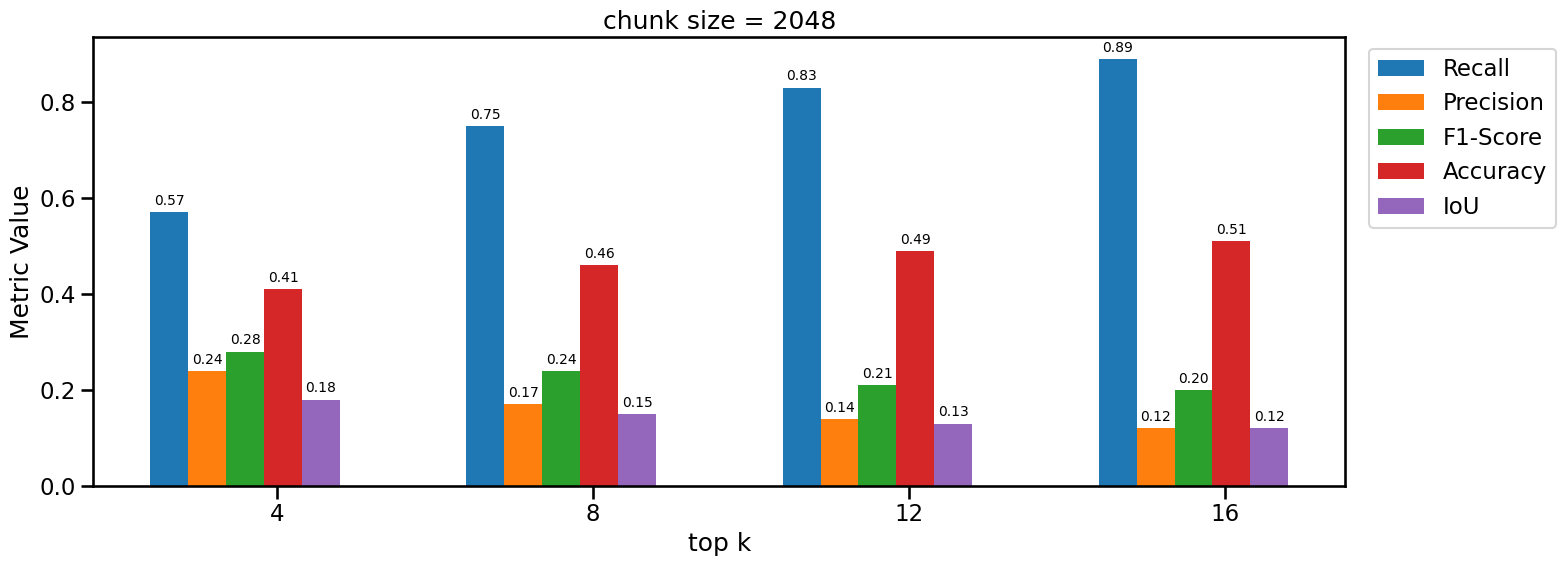

In [ ]:
sample_data = {
  4:  { "recall": 0.57, "precision": 0.24, "f1": 0.28, "accuracy": 0.41, "iou": 0.18 },
  8:  { "recall": 0.75, "precision": 0.17, "f1": 0.24, "accuracy": 0.46, "iou": 0.15 },
  12: { "recall": 0.83, "precision": 0.14, "f1": 0.21, "accuracy": 0.49, "iou": 0.13 },
  16: { "recall": 0.89, "precision": 0.12, "f1": 0.20, "accuracy": 0.51, "iou": 0.12 }
}

plot_metrics_by_span(sample_data, dataset_name="chunk size = 2048")


In [ ]:
key_txt = f"k={k_retriever}, size={chunk_size}, eval=word"
if use_reranker:
  key_txt += "w/reranker"

score = m_word.compute()
gpu_aggregate_scores[key_txt] = {
    "precision": score["Rouge-L-P"],
    "recall": score["Rouge-L-R"],
    "f1": score["Rouge-L-F"],
}

key_txt = f"k={k_retriever}, size={chunk_size}, eval=line"
if use_reranker:
  key_txt += "w/reranker"

score = m_line.compute()
gpu_aggregate_scores[key_txt] = {
    "precision": score["Rouge-L-P"],
    "recall": score["Rouge-L-R"],
    "f1": score["Rouge-L-F"],
}

gpu_aggregate_scores

In [ ]:
score = m.compute()

key_txt = f"k={k_retriever}, size={chunk_size}, eval={eval_by}"
if use_reranker:
  key_txt += "w/reranker"

aggregate_scores[key_txt] = {
    "precision": score["Rouge-L-P"],
    "recall": score["Rouge-L-R"],
    "f1": score["Rouge-L-F"],
    # "iou": avg_iou
}

aggregate_scores

{'k=8, size=512, eval=line': {'precision': 0.21458842250415835,
  'recall': 0.3667833912799291,
  'f1': 0.22206813085100222},
 'k=8, size=512, eval=word': {'precision': 0.30632970576396845,
  'recall': 0.5584401982463527,
  'f1': 0.3312472294942863},
 'k=4, size=512, eval=line': {'precision': 0.2798933177064167,
  'recall': 0.26444789242756,
  'f1': 0.2212416998258091},
 'k=4, size=512, eval=word': {'precision': 0.41099156397738884,
  'recall': 0.4215051143686957,
  'f1': 0.3480273620780463},
 'k=16, size=512, eval=line': {'precision': 0.1570649970056034,
  'recall': 0.4940642558443573,
  'f1': 0.20166078377150617},
 'k=16, size=512, eval=word': {'precision': 0.21272858229879277,
  'recall': 0.6981155988258156,
  'f1': 0.28003097499257257},
 'k=12, size=512, eval=line': {'precision': 0.17898937051540803,
  'recall': 0.4362421889131127,
  'f1': 0.21220408281441522},
 'k=12, size=512, eval=word': {'precision': 0.24856905879070987,
  'recall': 0.6396475411618228,
  'f1': 0.303704818111989

In [ ]:
# # Initialize lists to store scores
# precision_scores = []
# recall_scores = []
# f1_scores = []
# iou_scores = []

# # Iterate through the results list and extract scores
# for result in results_lst:
#   precision_scores.append(result['precision'])
#   recall_scores.append(result['recall'])
#   f1_scores.append(result['f1_score'])
#   iou_scores.append(result['iou'])

# # Calculate the average of each score
# avg_precision = np.mean(precision_scores)
# avg_recall = np.mean(recall_scores)
# avg_f1 = np.mean(f1_scores)
# avg_iou = np.mean(iou_scores)

# # Print the average scores
# print(f"Average Precision: {avg_precision:.4f}")
# print(f"Average Recall: {avg_recall:.4f}")
# print(f"Average F1 Score: {avg_f1:.4f}")
# print(f"Average IoU: {avg_iou:.4f}")

Average Precision: 0.2146
Average Recall: 0.3668
Average F1 Score: 0.2221
Average IoU: 0.1335


In [ ]:
aggregate_scores

{'k=8, size=512, eval=line': {'precision': 0.21458842250415835,
  'recall': 0.3667833912799291,
  'f1': 0.22206813085100222},
 'k=8, size=512, eval=word': {'precision': 0.30632970576396845,
  'recall': 0.5584401982463527,
  'f1': 0.3312472294942863},
 'k=4, size=512, eval=line': {'precision': 0.2798933177064167,
  'recall': 0.26444789242756,
  'f1': 0.2212416998258091},
 'k=4, size=512, eval=word': {'precision': 0.41099156397738884,
  'recall': 0.4215051143686957,
  'f1': 0.3480273620780463},
 'k=16, size=512, eval=line': {'precision': 0.1570649970056034,
  'recall': 0.4940642558443573,
  'f1': 0.20166078377150617},
 'k=16, size=512, eval=word': {'precision': 0.21272858229879277,
  'recall': 0.6981155988258156,
  'f1': 0.28003097499257257}}

### Plot

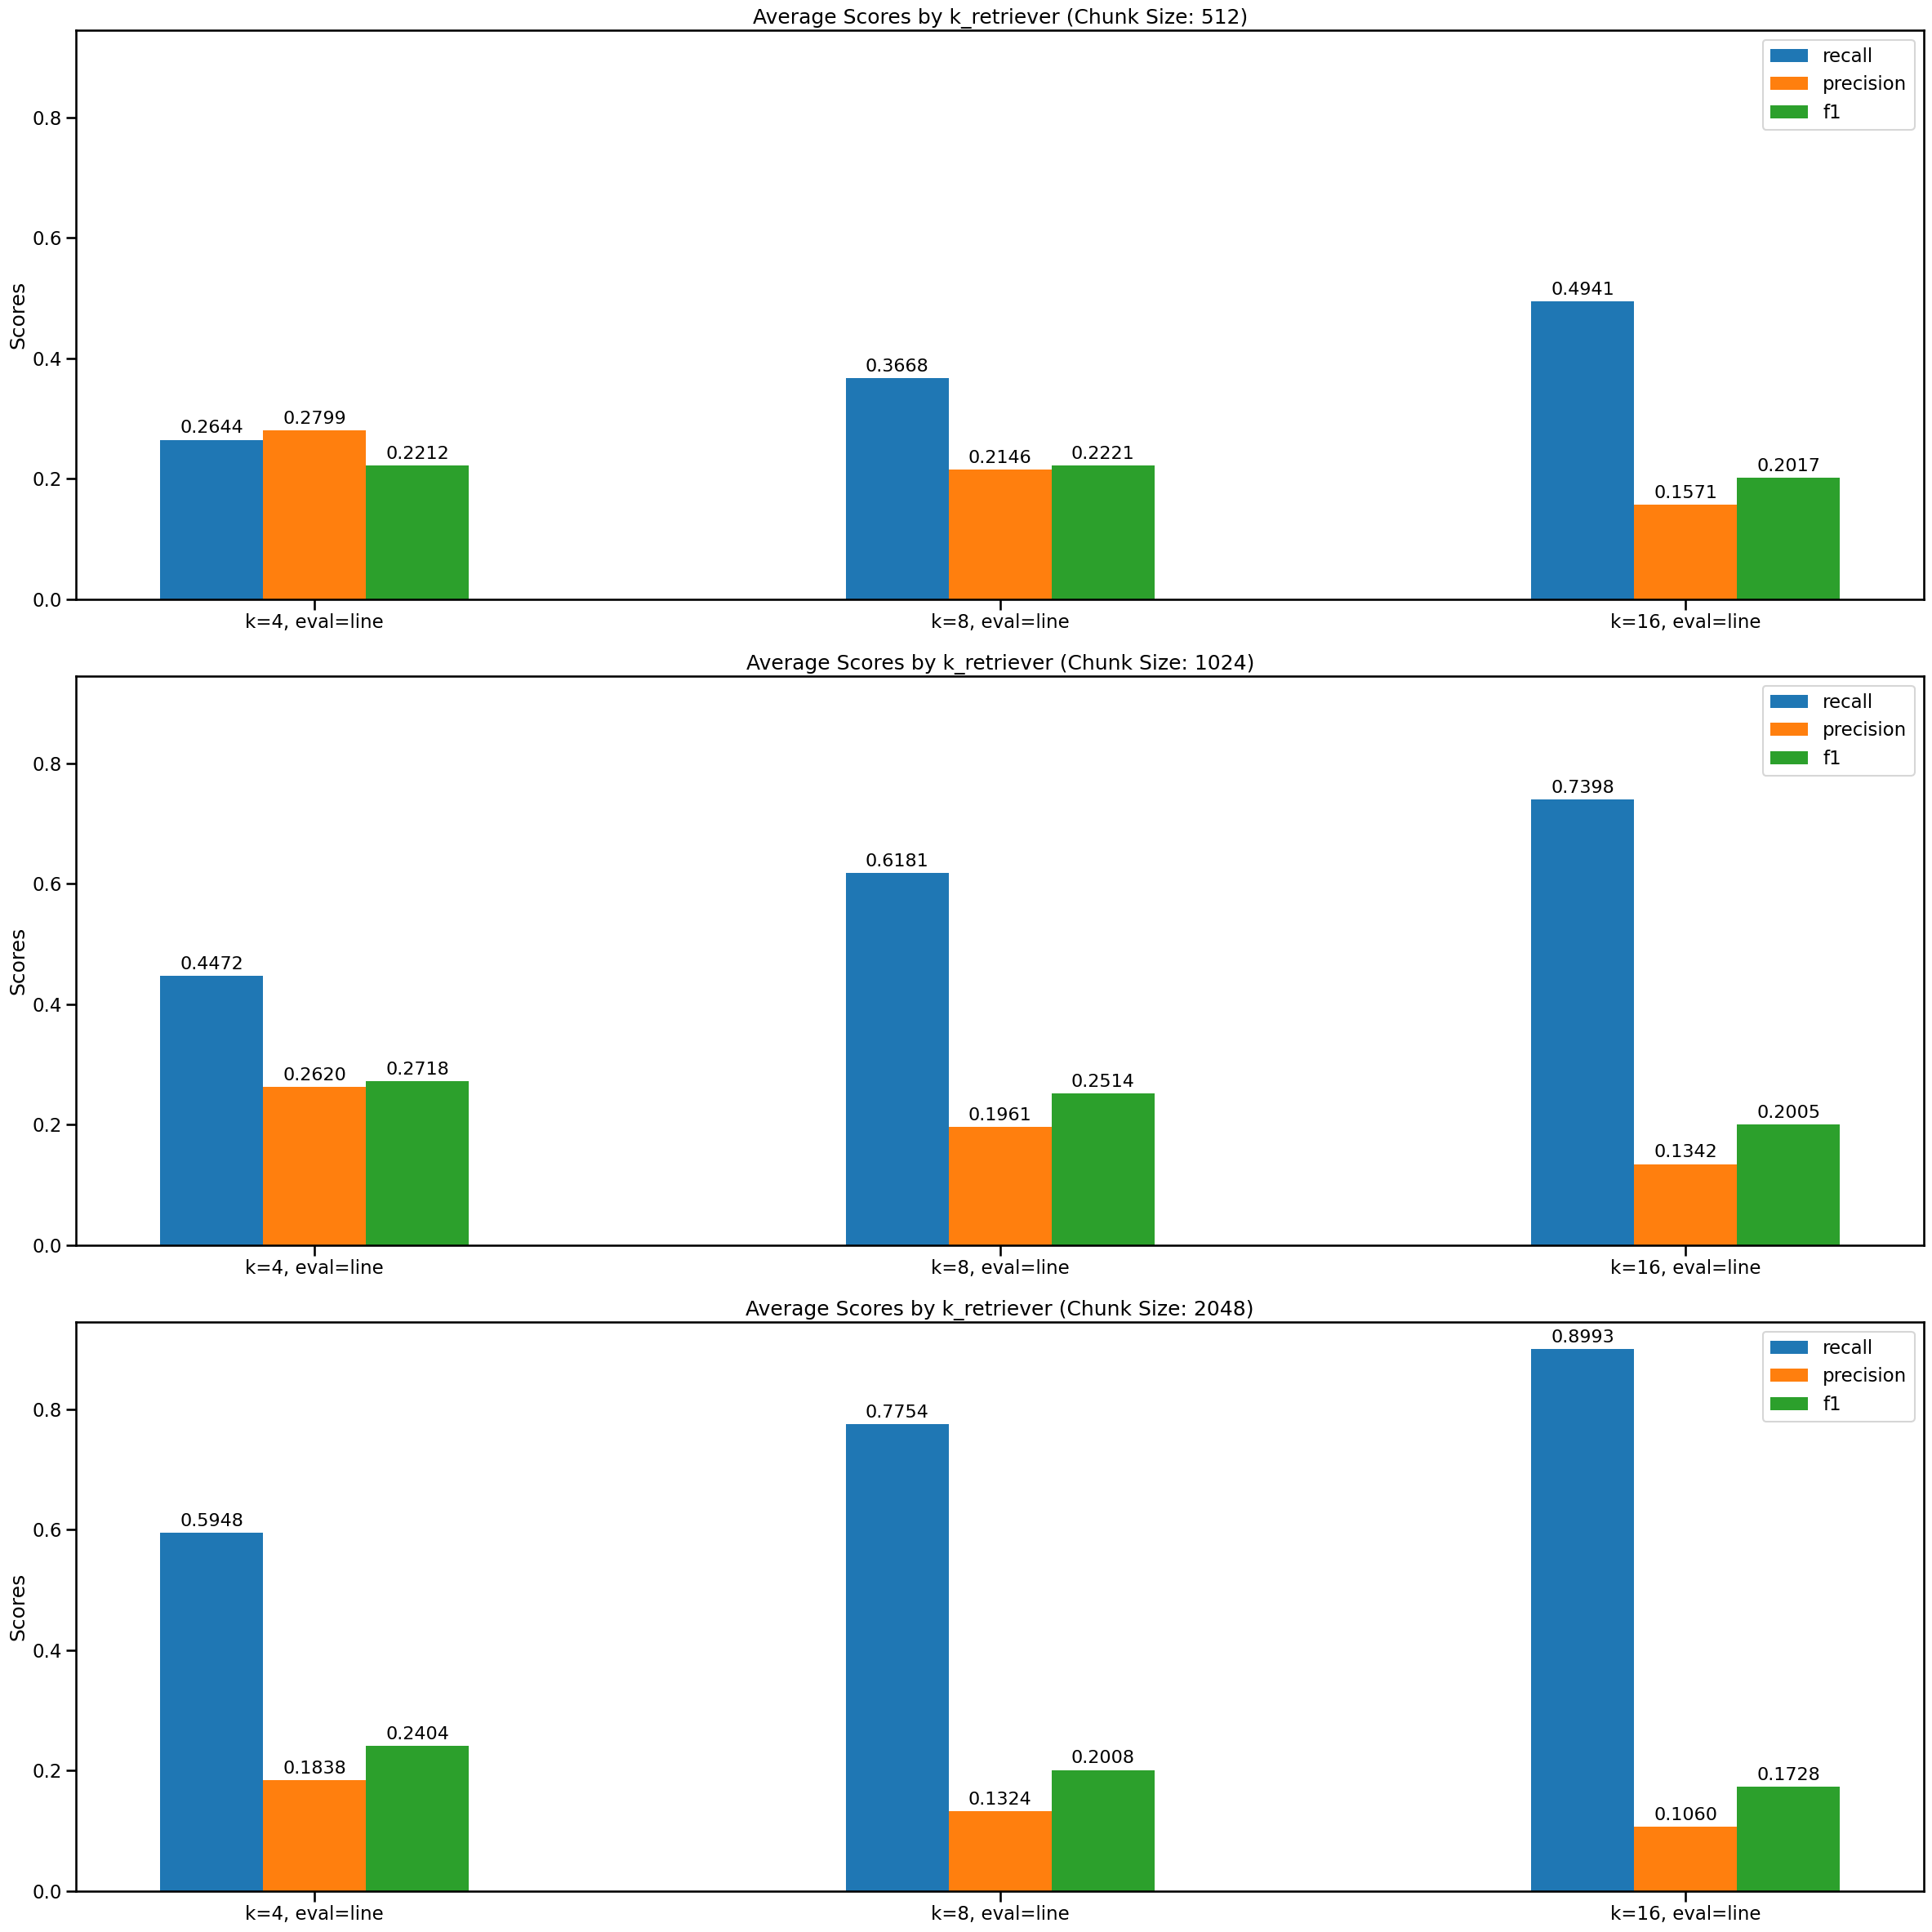

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

chunk_sizes = [512, 1024, 2048]
k_values = [4, 8, 16]
metrics = ['recall', 'precision', 'f1']

fig, axes = plt.subplots(len(chunk_sizes), 1, figsize=(24, 8 * len(chunk_sizes)), sharey=True)  # Create subplots

for row, chunk_size in enumerate(chunk_sizes):
    # Extract data for plotting for this chunk size
    plotting_groups = [f"k={k}, size={chunk_size}, eval=line" for k in k_values]
    plotting_data = [[aggregate_scores[group][metric] for group in plotting_groups] for metric in metrics]

    # Set up the plot for this subplot
    plotting_x = np.arange(len(plotting_groups))  # the label locations
    width = 0.15  # the width of the bars
    ax = axes[row]  # Get the current subplot

    # Create bars for each metric
    for i, metric in enumerate(metrics):
        rects = ax.bar(plotting_x + i * width, plotting_data[i], width, label=metric)

        # Annotate each bar with its score
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=16)

    # Add labels and title to the subplot
    ax.set_ylabel('Scores')
    ax.set_title(f'Average Scores by k_retriever (Chunk Size: {chunk_size})')
    ax.set_xticks(plotting_x + width * (len(metrics) - 1) / 2)
    ax.set_xticklabels([group_name.replace(f"size={chunk_size}, ", "") for group_name in plotting_groups])
    ax.legend(metrics)

fig.tight_layout()
plt.show()

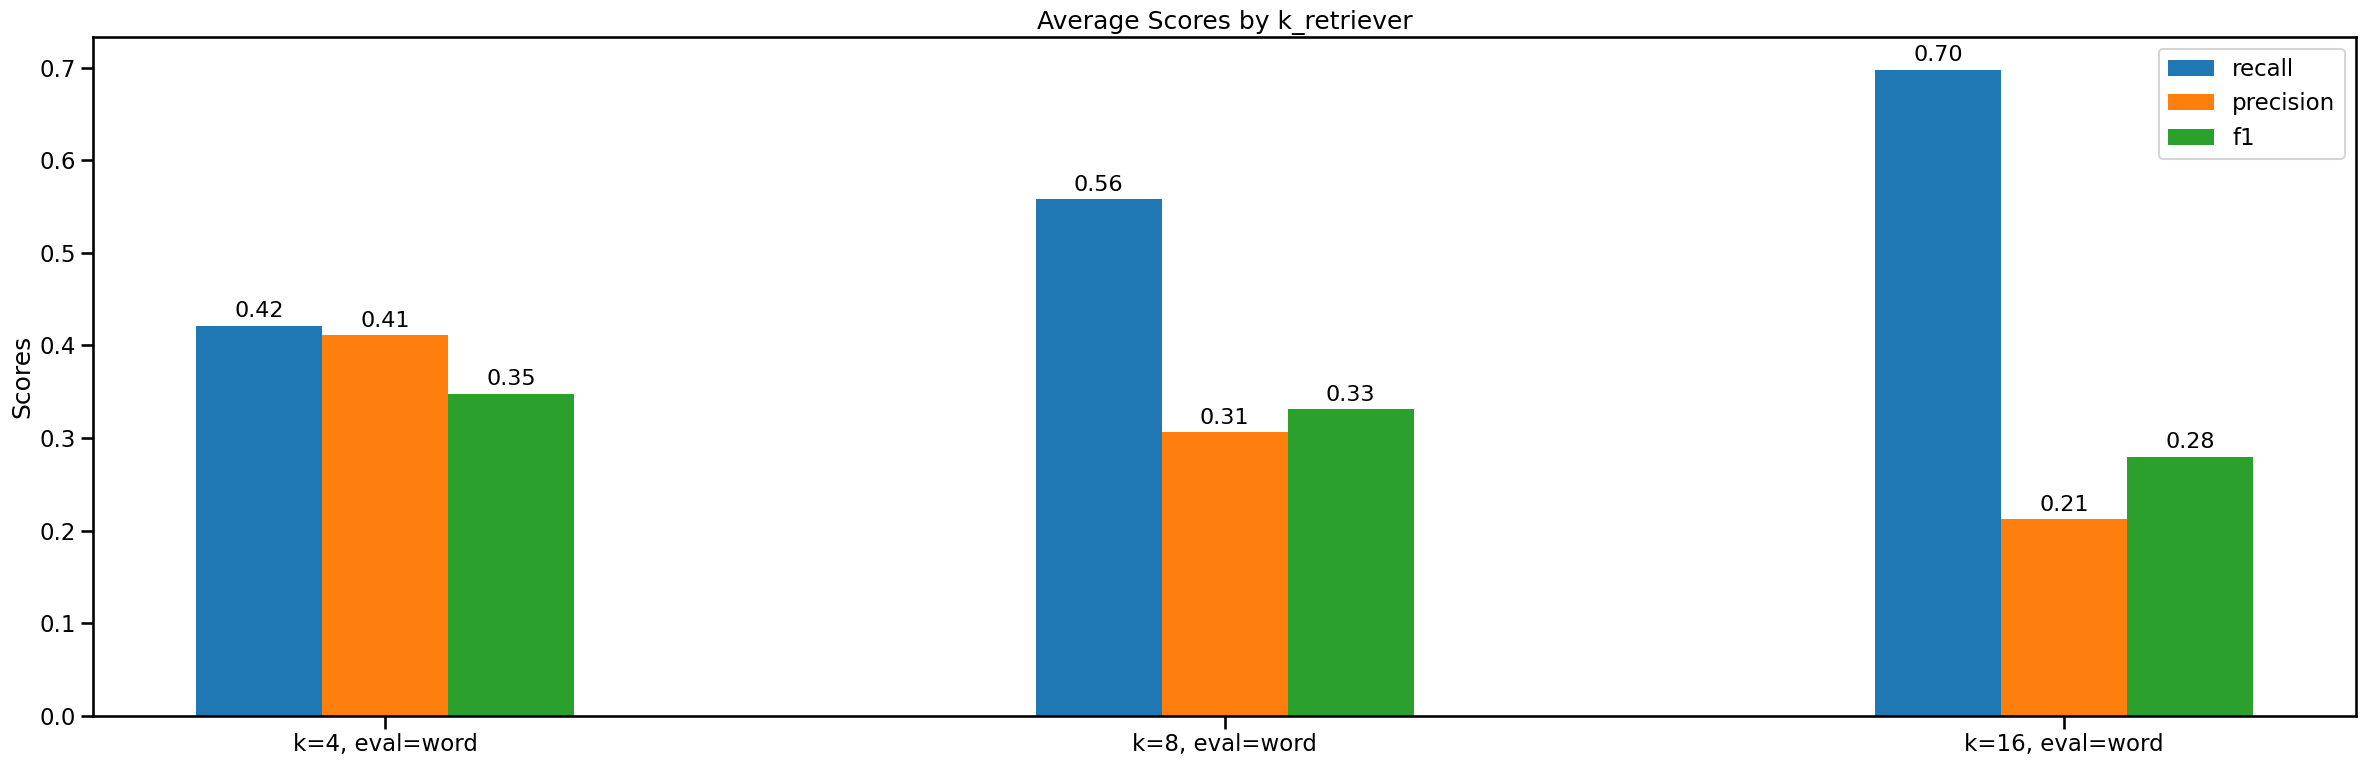

In [ ]:
plt_chunk_size = 2048

# Extract data for plotting
plotting_groups = [
    f"k=4, size=512, eval=word",
    f"k=8, size=512, eval=word",
    f"k=16, size=512, eval=word",
]
plotting_metrics = [
    'recall',
    'precision',
    'f1',
    # 'iou',
]

# Reshape data for plotting
plotting_data = [[aggregate_scores[group][metric] for group in plotting_groups] for metric in plotting_metrics]

# Set up the plot
plotting_x = np.arange(len(plotting_groups))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(24, 8))

# Create bars for each metric
for i, metric in enumerate(plotting_metrics):
    rects = ax.bar(plotting_x + i * width, plotting_data[i], width, label=metric)

    # Annotate each bar with its score
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',  # format to 2 decimal places
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom',
            fontsize=16
        )

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Average Scores by k_retriever')
ax.set_xticks(plotting_x + width * (len(plotting_metrics) - 1) / 2)  # Center the x-axis ticks
ax.set_xticklabels([group_name.replace("size=512, ", "") for group_name in plotting_groups])
ax.legend(plotting_metrics)

fig.tight_layout()
plt.show()

In [ ]:
def lcs_lines(retrieved_lines, relevant_lines):
    """
    Computes both the length and the actual Longest Common Subsequence (LCS) as a list of lines
    between two lists of lines (retrieved_lines and relevant_lines).

    Parameters:
        retrieved_lines (list of str): The retrieved lines.
        relevant_lines (list of str): The ground truth lines.

    Returns:
        tuple: (lcs_length, lcs_sequence) where lcs_length is an integer and lcs_sequence is a list of lines.
    """
    m = len(retrieved_lines)
    n = len(relevant_lines)

    # Build DP table (dimensions: (m+1) x (n+1)) for LCS lengths
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    # Populate the DP table
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if retrieved_lines[i - 1] == relevant_lines[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

    # Backtracking to reconstruct the LCS sequence from the DP table
    lcs_sequence = []
    i, j = m, n
    while i > 0 and j > 0:
        if retrieved_lines[i - 1] == relevant_lines[j - 1]:
            # When there's a match, it belongs to the LCS.
            lcs_sequence.append(retrieved_lines[i - 1])
            i -= 1
            j -= 1
        elif dp[i - 1][j] >= dp[i][j - 1]:
            i -= 1
        else:
            j -= 1

    # Reverse the sequence because we built it backwards
    lcs_sequence.reverse()
    lcs_length = dp[m][n]

    return lcs_length, lcs_sequence


def evaluate_retrieval_lines(retrieved_passages, relevant_passages):
    """
    Evaluates the correctness of retrieved passages (as lists of lines) against
    ground truth (relevant) passages at the "line" level.

    For each metric, we consider the LCS (line-level) as the count of true positives (TP).
    The metrics are defined as follows:
      - Precision: TP / (# retrieved lines)
      - Recall: TP / (# relevant lines)
      - IoU: TP / (# retrieved lines + # relevant lines − TP)
      - F1 Score: 2 * Precision * Recall / (Precision + Recall) (if both > 0)

    Parameters:
        retrieved_passages (list of str): List where each element is a line from the retrieved text.
        relevant_passages (list of str): List where each element is a line from the ground truth text.

    Returns:
        dict: A dictionary containing the computed 'precision', 'recall', 'iou', 'f1_score', and 'accuracy'.
    """
    # Compute the LCS length on the line level
    tp, lcs_sequence = lcs_lines(retrieved_passages, relevant_passages)

    num_retrieved = len(retrieved_passages)
    num_relevant  = len(relevant_passages)

    # Avoid division by zero
    precision = tp / num_retrieved if num_retrieved > 0 else 0.0
    recall = tp / num_relevant if num_relevant > 0 else 0.0
    f1_score = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
    iou_denominator = num_retrieved + num_relevant - tp
    iou = tp / iou_denominator if iou_denominator > 0 else 0.0

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "iou": iou,
        "lcs_lines": lcs_sequence
    }

In [ ]:
# from ignite.metrics import RougeL

# m = RougeL(multiref="best")

# retrieved_lines = [
#     "Line 1: The quick brown fox",
#     "Line 2: jumps over the lazy dog",
#     "Line 3: Machine learning is fascinating",
#     "Line 4: and full of surprises."
# ]
# relevant_lines = [[
#     "Line 1: The quick brown fox",
#     "Line 2: jumps over the lazy dog",
#     "Line 3: Machine learning is incredibly fascinating",
#     "Line 4: and full of surprises."
# ]]

# m.update(([retrieved_lines], [relevant_lines]))

# print(retrieved_lines)
# print(relevant_lines)
# print(m.compute())
# m.reset()

### Reranker

In [ ]:
# from langchain.retrievers import ContextualCompressionRetriever
# from langchain.retrievers.document_compressors import CrossEncoderReranker
# from langchain_community.cross_encoders import HuggingFaceCrossEncoder

# # from mxbai_rerank import MxbaiRerankV2
# # reranker = MxbaiRerankV2("mixedbread-ai/mxbai-rerank-large-v2")

# reranker_model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-large")
# reranker = CrossEncoderReranker(model=reranker_model, top_n=5)
# # compression_retriever = ContextualCompressionRetriever(
# #     base_compressor=compressor, base_retriever=retriever
# # )

# reranked_docs = reranker.compress_documents(query=query, documents=docs)
# for doc in reranked_docs:
#   print(doc.metadata["lines_n"])

## Clustering

In [ ]:
# embed the groups that have been made from the breakpoints
semantic_group_embeddings = semantic_chunker.embed_semantic_groups(semantic_groups)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs val

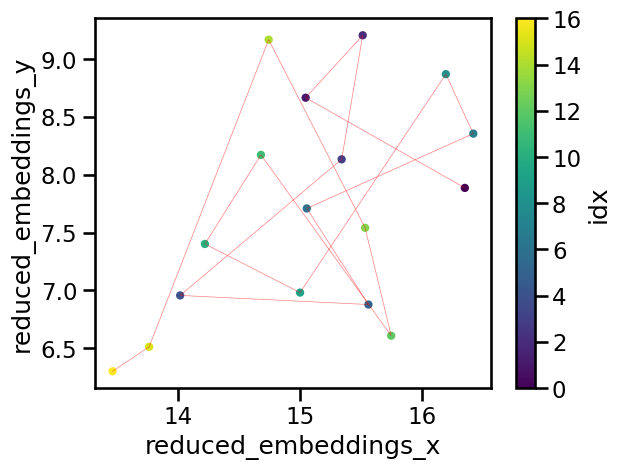

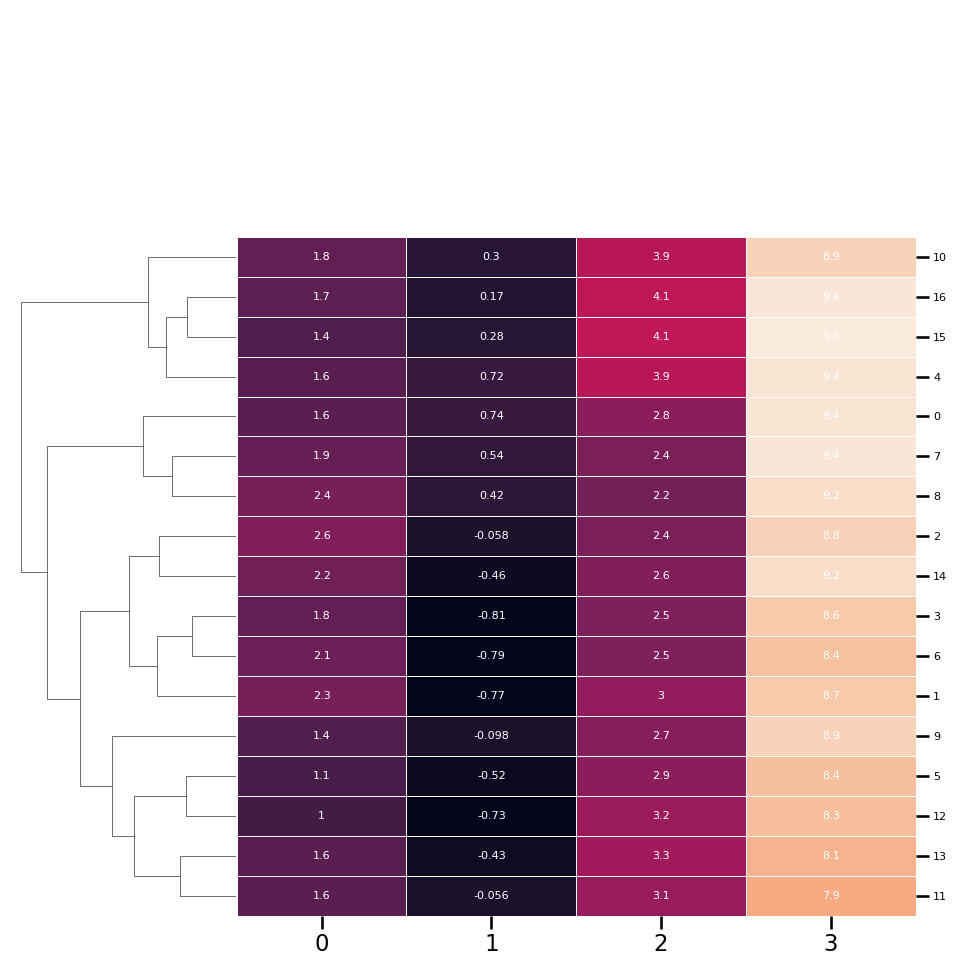

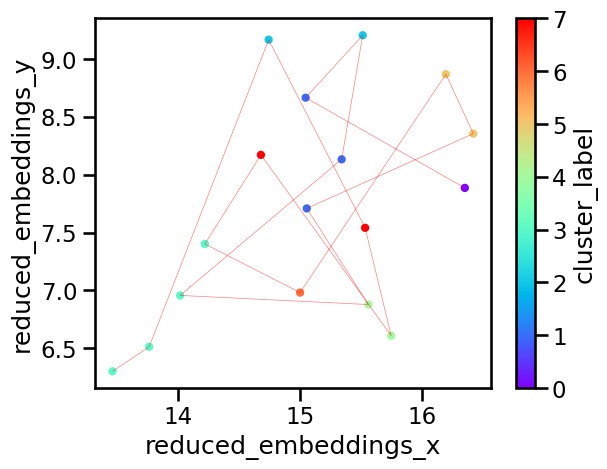

In [ ]:
# cluster the groups
splits_df, semantic_group_clusters = semantic_chunker.vizualize_semantic_groups(
    semantic_groups,
    semantic_group_embeddings,
    n_clusters=8
)

In [ ]:
# generate cluster summaries
cluster_summaries = semantic_chunker.generate_cluster_labels(
    semantic_group_clusters, plot=True
)

AttributeError: 'SentenceTransformer' object has no attribute 'embed_documents'

In [ ]:
# generate cluster bounds
semantic_cluster_bounds = semantic_chunker.split_visualizer.plot_corpus_and_clusters(
    splits_df, cluster_summaries
)